In [7]:
#IMPORT THE LIBRARIES
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import BatchNormalization , GRU
# from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import tensorflow as tf 
print ("Done")

Done


In [8]:
Crema = "/kaggle/input/cremad/AudioWAV/" # audios with different emotions
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()
print(Crema_df.Emotions.value_counts())

Emotions
disgust    1271
happy      1271
sad        1271
fear       1271
angry      1271
neutral    1087
Name: count, dtype: int64


In [9]:
# creating Dataframe using all the 4 dataframes we created so far.
# data_path = pd.concat([ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path = pd.concat([Crema_df], axis = 0)
data_path.to_csv("classified_crema.csv",index=False)
data_path.head()

,Emotions,Path
0,disgust,/kaggle/input/cremad/AudioWAV/1028_TSI_DIS_XX.wav
1,happy,/kaggle/input/cremad/AudioWAV/1075_IEO_HAP_LO.wav
2,happy,/kaggle/input/cremad/AudioWAV/1084_ITS_HAP_XX.wav
3,disgust,/kaggle/input/cremad/AudioWAV/1067_IWW_DIS_XX.wav
4,disgust,/kaggle/input/cremad/AudioWAV/1066_TIE_DIS_XX.wav


In [9]:
import librosa
import numpy as np
import csv
import time
import pywt  # Adding import statement for pywt

def extract_features(audio_file):
    start_time = time.time()
    # Load audio file
    y, sr = librosa.load(audio_file)
    
    # Time-domain features
    mean = np.mean(y)
    variance = np.var(y)
    skewness = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    kurtosis = np.mean(librosa.feature.spectral_flatness(y=y))
    zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y))
    rms_energy = np.mean(librosa.feature.rms(y=y))
    
    # Intensity (average energy)
    intensity = np.mean(np.abs(y))
    
    # Pitch (fundamental frequency)
    pitch = librosa.piptrack(y=y, sr=sr)[0]
    pitch_freqs = [max(pitch[:, i]) for i in range(pitch.shape[1]) if max(pitch[:, i]) > 0]
    if pitch_freqs:
        pitch = np.mean(pitch_freqs)
    else:
        pitch = 0
    
    # Frequency-domain features
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0].mean()
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0].mean()
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr).mean(axis=1)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0].mean()
    
    # Mel-frequency cepstral coefficients (MFCCs)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    
    # Chroma features
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_features = {f"chroma{i}": np.mean(chroma[i-1]) for i in range(1, chroma.shape[0] + 1)}
    
    # Spectral features
    spectral_flux = librosa.onset.onset_strength(y=y, sr=sr)
    spectral_flatness = librosa.feature.spectral_flatness(y=y)
    spectral_density = np.sum(librosa.stft(y), axis=1)  # Summing up magnitudes across frequency bins
    
    # Extract each spectral flux coefficient separately
    spectralflux_features = {}
    for i, flux_value in enumerate(spectral_flux):
        spectralflux_features[f"spectralflux{i+1}"] = np.mean(flux_value)
    
    # Extract each spectral density coefficient separately
    spectraldes_features = {}
    for i, density_value in enumerate(spectral_density):
        spectraldes_features[f"spectraldes{i+1}"] = np.mean(density_value)
    
    # Extract each spectral flatness coefficient separately
    spectralflatness_features = {}
    for i, flatness_value in enumerate(spectral_flatness):
        for j, value in enumerate(flatness_value):
            spectralflatness_features[f"spectralflatness{j+1}_{i+1}"] = value
    
    # Wavelet transform (example code, may need customization)
    coeffs, _ = pywt.dwt(y, 'db1')  # Example of using wavelet transform (you might need to adjust parameters)
    
    # Extract each wavelet coefficient separately
    waveletcoeffs_features = {}
    for i, coeff_value in enumerate(coeffs):
        waveletcoeffs_features[f"waveletcoeff{i+1}"] = np.mean(coeff_value)
    
    end_time = time.time()
    time_taken = end_time - start_time
    
    # Extract each MFCC coefficient separately
    mfcc_features = {}
    for i in range(1, 14):
        mfcc_features[f"mfcc{i}"] = np.mean(mfccs[i-1])
    
    return {
        "mean": mean,
        "variance": variance,
        "skewness": skewness,
        "kurtosis": kurtosis,
        "zero_crossing_rate": zero_crossing_rate,
        "rms_energy": rms_energy,
        "intensity": intensity,
        "pitch": pitch,
        "spectral_centroid": spectral_centroid,
        "spectral_bandwidth": spectral_bandwidth,
        **{f"spectralcontrast{i+1}": spectral_contrast[i] for i in range(len(spectral_contrast))},  # Unpack Spectral contrast features
        "spectral_rolloff": spectral_rolloff,
        **mfcc_features,  # Unpack MFCC coefficients
        **chroma_features,  # Unpack Chroma features
        **spectralflux_features,  # Unpack Spectral flux features
        **spectraldes_features,  # Unpack Spectral density features
        **spectralflatness_features,  # Unpack Spectral flatness features
        "time_taken": time_taken
    }
# Read audio file paths and their corresponding emotion labels from CSV
def read_audio_paths(csv_file):
    audio_paths = []
    with open(csv_file, mode='r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            audio_paths.append((row['Path'], row['Emotions']))  # Assuming 'Path' and 'Emotion' are the column names
    return audio_paths

# Example usage:
csv_file = "/kaggle/working/classified_crema.csv"
audio_paths = read_audio_paths(csv_file)

# List to store features of all audio files
all_features = []

# Start time for the entire dataset
total_start_time = time.time()

# Extract features for each audio file
for audio_path, emotion_label in audio_paths:
    features = extract_features(audio_path)
    features["Path"] = audio_path
    features["Emotions"] = emotion_label
    all_features.append(features)

# End time for the entire dataset
total_end_time = time.time()

# Total time taken for the entire dataset
total_time_taken = total_end_time - total_start_time

# Collect all feature names
all_feature_names = set()
for features in all_features:
    all_feature_names.update(features.keys())

# Create fieldnames list
fieldnames = list(all_feature_names)

# Write features to CSV file
output_csv_file = "cremafeatures.csv"
with open(output_csv_file, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(all_features)

print("Features extracted and stored in:", output_csv_file)
print("Total time taken for the entire dataset:", total_time_taken, "seconds")

Features extracted and stored in: cremafeatures.csv
Total time taken for the entire dataset: 5567.338131189346 seconds


In [10]:
import pandas as pd

# Read the CSV file
df = pd.read_csv("/kaggle/working/cremafeatures.csv")

# Get the number of rows and columns
num_rows, num_cols = df.shape

print("Number of rows:", num_rows)
print("Number of columns:", num_cols)

Number of rows: 7442
Number of columns: 1503


In [11]:
import pandas as pd

# Specify the path to your CSV file
csv_file_path = "/kaggle/working/cremafeatures.csv"
import pandas as pd

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file_path)

df.head()

,spectraldes262,spectraldes544,spectralflatness181_1,spectraldes426,spectraldes746,spectraldes726,spectralflux90,spectraldes275,spectraldes160,spectralflatness140_1,...,Path,spectralflux28,spectraldes543,spectraldes977,spectraldes466,spectralflatness97_1,spectraldes381,spectralflatness186_1,spectralflatness200_1,chroma7
0,(0.19224066+0.7077841j),(-0.18749548-0.10757173j),NaN,(-0.030205885-0.13271064j),(-0.0025469484+0.0013472532j),(-0.046941668-0.04917181j),1.888011,(0.0020199702+0.0032715145j),(-0.109744355-0.016602661j),NaN,...,/kaggle/input/cremad/AudioWAV/1028_TSI_DIS_XX.wav,1.495462,(0.011571253-0.00034571445j),(0.0027239437-0.00035959345j),(0.64089495+0.42163405j),0.000097,(1.0304838+0.16004579j),NaN,NaN,0.296761
1,(-0.40868753+0.3708154j),(-0.2718181-0.22720744j),NaN,(0.05460568+0.012238255j),(0.0022054263-0.0016761541j),(-0.002010294+0.0049419357j),NaN,(-0.0068055894+0.0012412332j),(0.62655306+0.5976946j),NaN,...,/kaggle/input/cremad/AudioWAV/1075_IEO_HAP_LO.wav,0.416818,(0.0014030817+0.0003186562j),(-0.0027413142+0.00040927096j),(-0.012108351-0.12355296j),NaN,(-0.76509356+0.1339696j),NaN,NaN,0.403676
2,(-0.10479176-0.6921882j),(0.59819764-0.24903673j),NaN,(-0.026625453-0.20918092j),(7.2915194e-05-0.00016910386j),(-0.06264088+0.052092247j),2.405509,(-0.0013979205-0.0008719737j),(-0.46386012-0.2662455j),NaN,...,/kaggle/input/cremad/AudioWAV/1084_ITS_HAP_XX.wav,0.996662,(0.00094908016-0.0011950082j),(-9.6804324e-05+1.3601747e-05j),(-1.1318462+0.09621374j),0.000043,(-0.37340644-0.8898328j),NaN,NaN,0.339908
3,(0.7174345+0.29844886j),(-0.037172448+0.15842095j),NaN,(-0.27236125+0.41641814j),(-0.002319824+0.0012163975j),(-0.0054735644-0.027331067j),0.498122,(-0.0012475431-4.5230176e-05j),(0.05549605-0.2301655j),NaN,...,/kaggle/input/cremad/AudioWAV/1067_IWW_DIS_XX.wav,0.622588,(0.006796782+0.0019893725j),(0.002146787-0.0002646397j),(0.57181513-0.77152056j),0.000101,(-0.10727085+0.9871551j),NaN,NaN,0.393899
4,(0.096399255+1.176411j),(-0.049075432+0.18062578j),NaN,(-0.3308068-0.26168925j),(0.00018523698-0.00054140016j),(0.021511452-0.001420998j),1.541178,(0.00039213803+0.0098241065j),(3.3970475-3.3013008j),NaN,...,/kaggle/input/cremad/AudioWAV/1066_TIE_DIS_XX.wav,1.575530,(0.0029942142-0.0037559625j),(-0.0005212237+9.927392e-05j),(0.32076067+0.07544771j),0.000107,(-0.614431+0.118758224j),NaN,NaN,0.422874


In [12]:
import pandas as pd

# Read the CSV file
input_file = "/kaggle/working/cremafeatures.csv"
output_file = "crema_features.csv"

data = pd.read_csv(input_file)

# Define the character you want to remove
character_to_remove = "("

# Remove the specified character from the DataFrame
data = data.applymap(lambda x: x.replace(character_to_remove, '') if isinstance(x, str) else x)

# Write the modified DataFrame back to a new CSV file
data.to_csv(output_file, index=False)

print("Character '{}' removed from the CSV file.".format(character_to_remove))


Character '(' removed from the CSV file.


In [13]:
import pandas as pd

# Read the CSV file
input_file = "/kaggle/working/crema_features.csv"
output_file = "crema_extracted_feature.csv"

data = pd.read_csv(input_file)

# Define the character you want to remove
character_to_remove = ")"

# Remove the specified character from the DataFrame
data = data.applymap(lambda x: x.replace(character_to_remove, '') if isinstance(x, str) else x)

# Write the modified DataFrame back to a new CSV file
data.to_csv(output_file, index=False)

print("Character '{}' removed from the CSV file.".format(character_to_remove))


Character ')' removed from the CSV file.


In [14]:
import pandas as pd

# Read the CSV file
input_file = "/kaggle/working/crema_extracted_feature.csv"
output_file = "LibrosaExtractedFeaturesCrema.csv"

data = pd.read_csv(input_file)

# Define the alphabet you want to remove
alphabet_to_remove = 'j'

# Remove the specified alphabet from the DataFrame
data = data.applymap(lambda x: x.replace(alphabet_to_remove, '') if isinstance(x, str) else x)

# Write the modified DataFrame back to a new CSV file
data.to_csv(output_file, index=False)

print("Alphabet '{}' removed from the CSV file.".format(alphabet_to_remove))


Alphabet 'j' removed from the CSV file.


In [15]:
import pandas as pd

# Specify the path to your CSV file
csv_file_path = "/kaggle/working/LibrosaExtractedFeaturesCrema.csv"
outputfile = ""
import pandas as pd

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file_path)

df.head()


,spectraldes262,spectraldes544,spectralflatness181_1,spectraldes426,spectraldes746,spectraldes726,spectralflux90,spectraldes275,spectraldes160,spectralflatness140_1,...,Path,spectralflux28,spectraldes543,spectraldes977,spectraldes466,spectralflatness97_1,spectraldes381,spectralflatness186_1,spectralflatness200_1,chroma7
0,0.19224066+0.7077841,-0.18749548-0.10757173,NaN,-0.030205885-0.13271064,-0.0025469484+0.0013472532,-0.046941668-0.04917181,1.888011,0.0020199702+0.0032715145,-0.109744355-0.016602661,NaN,...,/kaggle/input/cremad/AudioWAV/1028_TSI_DIS_XX.wav,1.495462,0.011571253-0.00034571445,0.0027239437-0.00035959345,0.64089495+0.42163405,0.000097,1.0304838+0.16004579,NaN,NaN,0.296761
1,-0.40868753+0.3708154,-0.2718181-0.22720744,NaN,0.05460568+0.012238255,0.0022054263-0.0016761541,-0.002010294+0.0049419357,NaN,-0.0068055894+0.0012412332,0.62655306+0.5976946,NaN,...,/kaggle/input/cremad/AudioWAV/1075_IEO_HAP_LO.wav,0.416818,0.0014030817+0.0003186562,-0.0027413142+0.00040927096,-0.012108351-0.12355296,NaN,-0.76509356+0.1339696,NaN,NaN,0.403676
2,-0.10479176-0.6921882,0.59819764-0.24903673,NaN,-0.026625453-0.20918092,7.2915194e-05-0.00016910386,-0.06264088+0.052092247,2.405509,-0.0013979205-0.0008719737,-0.46386012-0.2662455,NaN,...,/kaggle/input/cremad/AudioWAV/1084_ITS_HAP_XX.wav,0.996662,0.00094908016-0.0011950082,-9.6804324e-05+1.3601747e-05,-1.1318462+0.09621374,0.000043,-0.37340644-0.8898328,NaN,NaN,0.339908
3,0.7174345+0.29844886,-0.037172448+0.15842095,NaN,-0.27236125+0.41641814,-0.002319824+0.0012163975,-0.0054735644-0.027331067,0.498122,-0.0012475431-4.5230176e-05,0.05549605-0.2301655,NaN,...,/kaggle/input/cremad/AudioWAV/1067_IWW_DIS_XX.wav,0.622588,0.006796782+0.0019893725,0.002146787-0.0002646397,0.57181513-0.77152056,0.000101,-0.10727085+0.9871551,NaN,NaN,0.393899
4,0.096399255+1.176411,-0.049075432+0.18062578,NaN,-0.3308068-0.26168925,0.00018523698-0.00054140016,0.021511452-0.001420998,1.541178,0.00039213803+0.0098241065,3.3970475-3.3013008,NaN,...,/kaggle/input/cremad/AudioWAV/1066_TIE_DIS_XX.wav,1.575530,0.0029942142-0.0037559625,-0.0005212237+9.927392e-05,0.32076067+0.07544771,0.000107,-0.614431+0.118758224,NaN,NaN,0.422874


In [18]:
import pandas as pd

# Read CSV file
df = pd.read_csv('/kaggle/working/LibrosaExtractedFeaturesCrema.csv')

# Iterate over each cell in the DataFrame
for column in df.columns:
    df[column] = df[column].apply(lambda x: '=' + x if isinstance(x, str) and not x.startswith('=') else x)

# Save the modified DataFrame back to a new CSV file
df.to_csv('output_file_crema.csv', index=False)


In [21]:
import pandas as pd

# Specify the path to your CSV file
csv_file_path = "/kaggle/working/output_file_crema.csv"
outputfile = ""
import pandas as pd

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file_path)

df.head()


,spectraldes262,spectraldes544,spectralflatness181_1,spectraldes426,spectraldes746,spectraldes726,spectralflux90,spectraldes275,spectraldes160,spectralflatness140_1,...,Path,spectralflux28,spectraldes543,spectraldes977,spectraldes466,spectralflatness97_1,spectraldes381,spectralflatness186_1,spectralflatness200_1,chroma7
0,=0.19224066+0.7077841,=-0.18749548-0.10757173,NaN,=-0.030205885-0.13271064,=-0.0025469484+0.0013472532,=-0.046941668-0.04917181,1.888011,=0.0020199702+0.0032715145,=-0.109744355-0.016602661,NaN,...,=/kaggle/input/cremad/AudioWAV/1028_TSI_DIS_XX...,1.495462,=0.011571253-0.00034571445,=0.0027239437-0.00035959345,=0.64089495+0.42163405,0.000097,=1.0304838+0.16004579,NaN,NaN,0.296761
1,=-0.40868753+0.3708154,=-0.2718181-0.22720744,NaN,=0.05460568+0.012238255,=0.0022054263-0.0016761541,=-0.002010294+0.0049419357,NaN,=-0.0068055894+0.0012412332,=0.62655306+0.5976946,NaN,...,=/kaggle/input/cremad/AudioWAV/1075_IEO_HAP_LO...,0.416818,=0.0014030817+0.0003186562,=-0.0027413142+0.00040927096,=-0.012108351-0.12355296,NaN,=-0.76509356+0.1339696,NaN,NaN,0.403676
2,=-0.10479176-0.6921882,=0.59819764-0.24903673,NaN,=-0.026625453-0.20918092,=7.2915194e-05-0.00016910386,=-0.06264088+0.052092247,2.405509,=-0.0013979205-0.0008719737,=-0.46386012-0.2662455,NaN,...,=/kaggle/input/cremad/AudioWAV/1084_ITS_HAP_XX...,0.996662,=0.00094908016-0.0011950082,=-9.6804324e-05+1.3601747e-05,=-1.1318462+0.09621374,0.000043,=-0.37340644-0.8898328,NaN,NaN,0.339908
3,=0.7174345+0.29844886,=-0.037172448+0.15842095,NaN,=-0.27236125+0.41641814,=-0.002319824+0.0012163975,=-0.0054735644-0.027331067,0.498122,=-0.0012475431-4.5230176e-05,=0.05549605-0.2301655,NaN,...,=/kaggle/input/cremad/AudioWAV/1067_IWW_DIS_XX...,0.622588,=0.006796782+0.0019893725,=0.002146787-0.0002646397,=0.57181513-0.77152056,0.000101,=-0.10727085+0.9871551,NaN,NaN,0.393899
4,=0.096399255+1.176411,=-0.049075432+0.18062578,NaN,=-0.3308068-0.26168925,=0.00018523698-0.00054140016,=0.021511452-0.001420998,1.541178,=0.00039213803+0.0098241065,=3.3970475-3.3013008,NaN,...,=/kaggle/input/cremad/AudioWAV/1066_TIE_DIS_XX...,1.575530,=0.0029942142-0.0037559625,=-0.0005212237+9.927392e-05,=0.32076067+0.07544771,0.000107,=-0.614431+0.118758224,NaN,NaN,0.422874


In [2]:
import pandas as pd

# Specify the path to your CSV file
csv_file_path = "/kaggle/input/outputcrema/output_file_crema.csv"
outputfile = ""
import pandas as pd

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file_path)

df.head()


,spectraldes262,spectraldes544,spectralflatness181_1,spectraldes426,spectraldes746,spectraldes726,spectralflux90,spectraldes275,spectraldes160,spectralflatness140_1,...,Path,spectralflux28,spectraldes543,spectraldes977,spectraldes466,spectralflatness97_1,spectraldes381,spectralflatness186_1,spectralflatness200_1,chroma7
0,0.900025,-0.295067,NaN,-0.162917,-0.001200,-0.096113,1.888011,0.005291,-0.126347,NaN,...,=/kaggle/input/cremad/AudioWAV/1028_TSI_DIS_XX...,1.495462,0.011226,0.002364,1.062529,0.000097,1.190530,NaN,NaN,0.296761
1,-0.037872,-0.499026,NaN,0.066844,0.000529,0.002932,NaN,-0.005564,1.224248,NaN,...,=/kaggle/input/cremad/AudioWAV/1075_IEO_HAP_LO...,0.416818,0.001722,-0.002332,-0.135661,NaN,-0.631124,NaN,NaN,0.403676
2,-0.796980,0.349161,NaN,-0.235806,-0.000096,-0.010549,2.405509,-0.002270,-0.730106,NaN,...,=/kaggle/input/cremad/AudioWAV/1084_ITS_HAP_XX...,0.996662,-0.000246,-0.000083,-1.035632,0.000043,-1.263239,NaN,NaN,0.339908
3,1.015883,0.121249,NaN,0.144057,-0.001103,-0.032805,0.498122,-0.001293,-0.174669,NaN,...,=/kaggle/input/cremad/AudioWAV/1067_IWW_DIS_XX...,0.622588,0.008786,0.001882,-0.199705,0.000101,0.879884,NaN,NaN,0.393899
4,1.272810,0.131550,NaN,-0.592496,-0.000356,0.020090,1.541178,0.010216,0.095747,NaN,...,=/kaggle/input/cremad/AudioWAV/1066_TIE_DIS_XX...,1.575530,-0.000762,-0.000422,0.396208,0.000107,-0.495673,NaN,NaN,0.422874


In [3]:
import pandas as pd

# Read CSV file
df = pd.read_csv('/kaggle/input/outputcrema/output_file_crema.csv')

# Drop a specific column
column_to_drop = 'Path'
df.drop(column_to_drop, axis=1, inplace=True)


# You can also save the modified DataFrame back to a CSV file if needed
df.to_csv('ExtractedFeaturesForCremaDataset.csv', index=False)


In [4]:
import pandas as pd

# Read CSV file
df = pd.read_csv('/kaggle/working/ExtractedFeaturesForCremaDataset.csv')

# Convert string values to float for all columns
for column in df.columns:
    # Check if the column contains string values
    if df[column].dtype == 'object':
        # Use try-except to handle potential conversion errors
        try:
            df[column] = df[column].str.replace(',', '').astype(float)
            # If your string values contain commas as thousands separators, remove them with .str.replace(',', '')
        except ValueError:
            print(f"Unable to convert values in column '{column}' to float.")

# Now, string values that could be converted to float have been converted.
# If any value couldn't be converted, it remains as is.

# You can also save the modified DataFrame back to a CSV file if needed
# df.to_csv('output_file.csv', index=False)


Unable to convert values in column 'Emotions' to float.


In [10]:
import pandas as pd

# Read the first CSV file
csv1 = pd.read_csv("/kaggle/working/classified_crema.csv")

# Read the second CSV file
csv2 = pd.read_csv("/kaggle/working/ExtractedFeaturesForCremaDataset.csv")

# Copy the 'Emotions' column from csv1 to csv2
csv2['Emotions'] = csv1['Emotions']

# Save the modified csv2 to a new CSV file
csv2.to_csv("/kaggle/working/ExtractedFeaturesForCremaDatasetLibrosa.csv", index=False)

print("Emotions column copied from csv1 to csv2 and saved to output.csv")


Emotions column copied from csv1 to csv2 and saved to output.csv


In [11]:
import pandas as pd

# Read CSV file
data = pd.read_csv('/kaggle/working/ExtractedFeaturesForCremaDatasetLibrosa.csv')

# Check unique values in the 'Emotions' column
unique_emotions = data['Emotions'].unique()

# Print unique values
print("Unique values in the 'Emotions' column:")
print(unique_emotions)


Unique values in the 'Emotions' column:
['disgust' 'happy' 'sad' 'neutral' 'fear' 'angry']


In [12]:
import pandas as pd

# Read the CSV file into a pandas DataFrame
data = pd.read_csv('/kaggle/working/ExtractedFeaturesForCremaDatasetLibrosa.csv')

# Fill NaN values with 0
data.fillna(0, inplace=True)

# Now, save the DataFrame back to a CSV file if needed
data.to_csv('/kaggle/working/ExtractedFeaturesForCremaDatasetLibrosaCleanedNa.csvv', index=False)


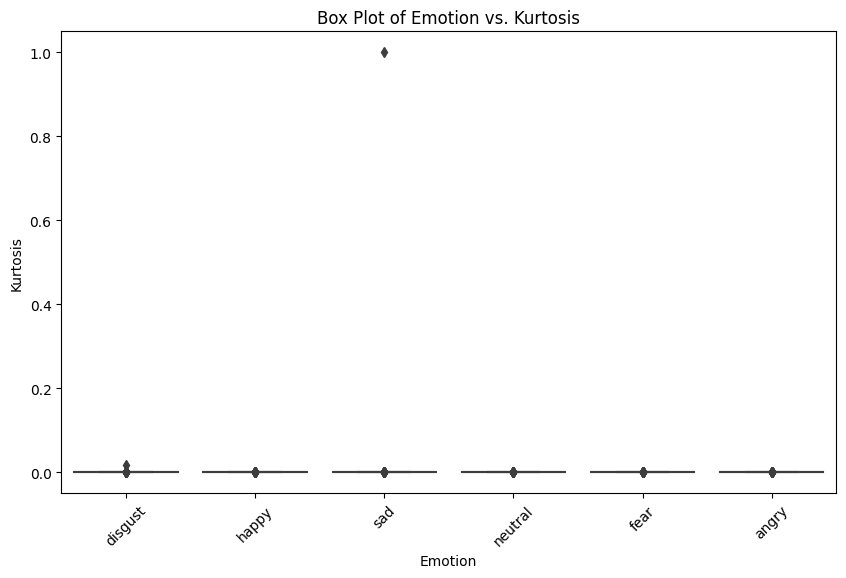

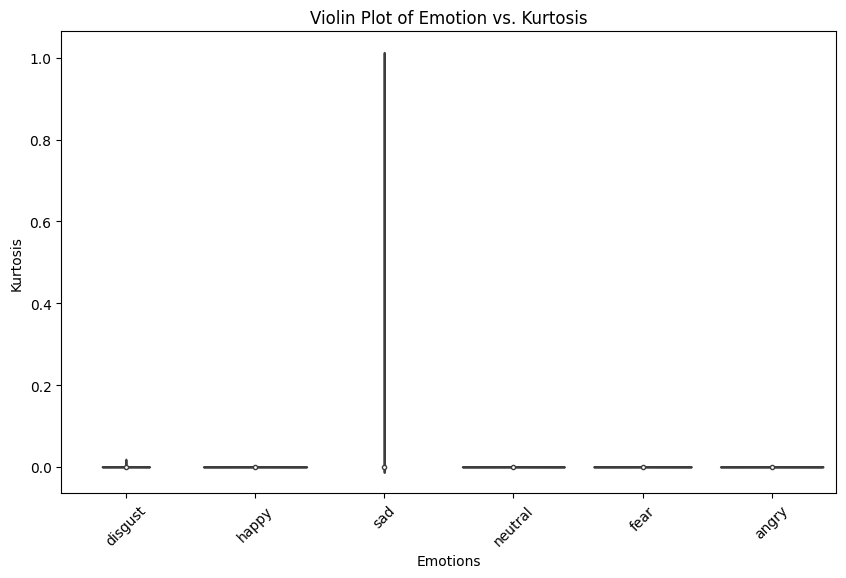

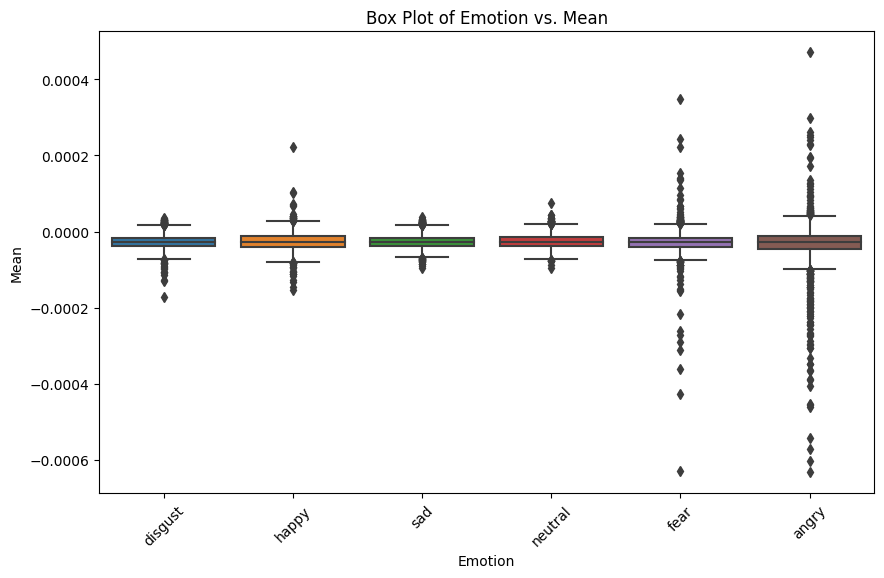

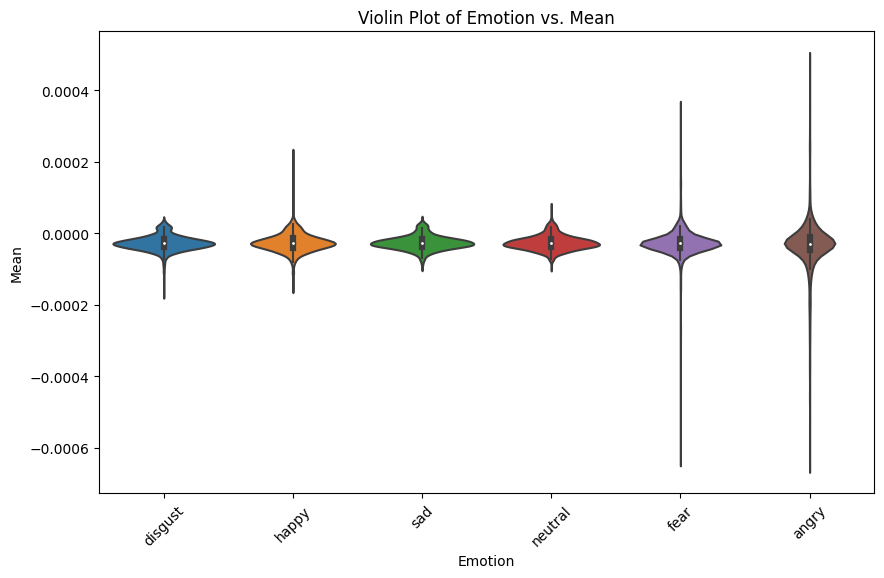

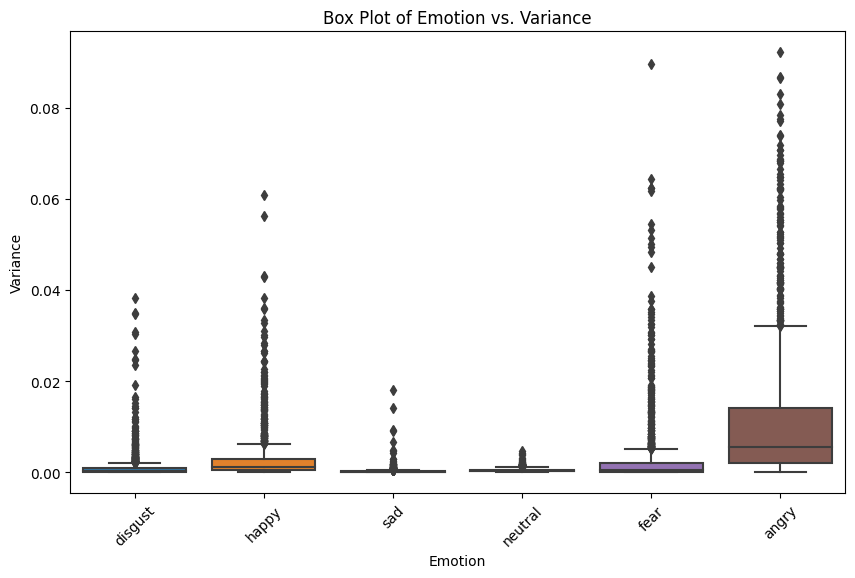

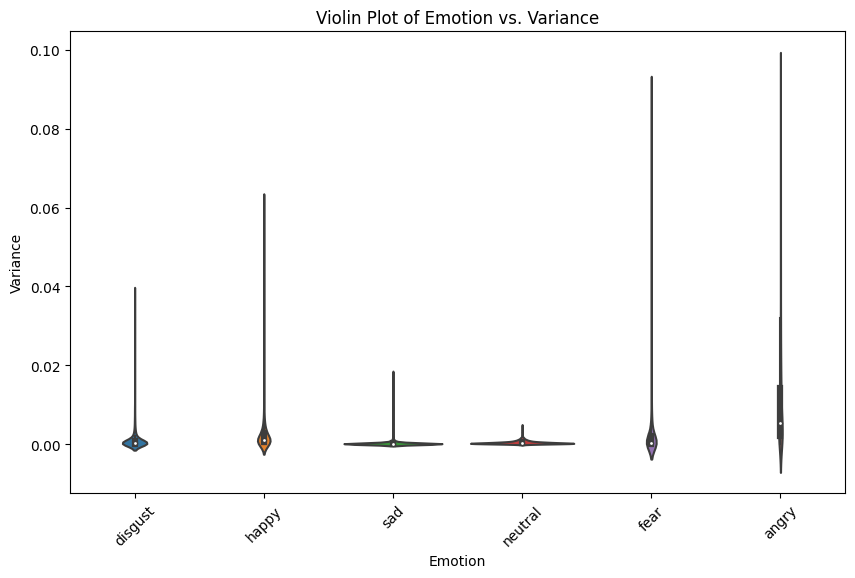

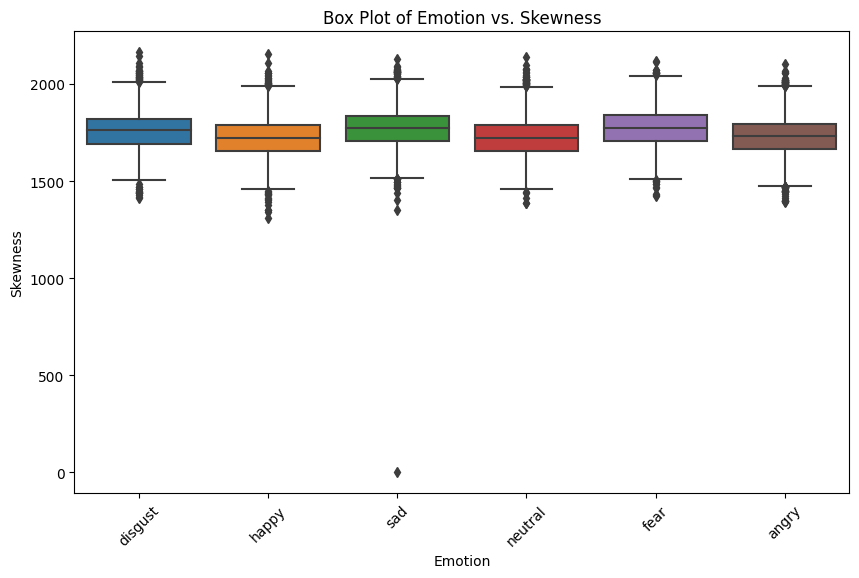

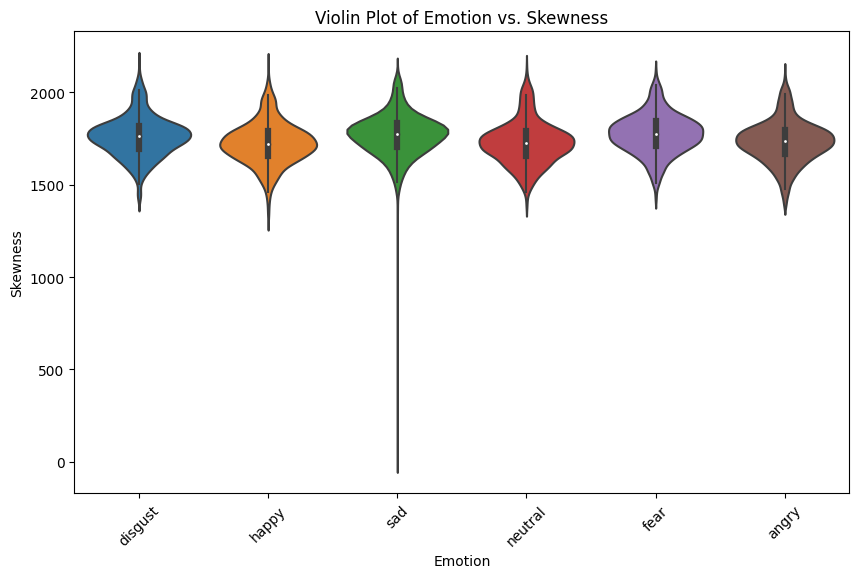

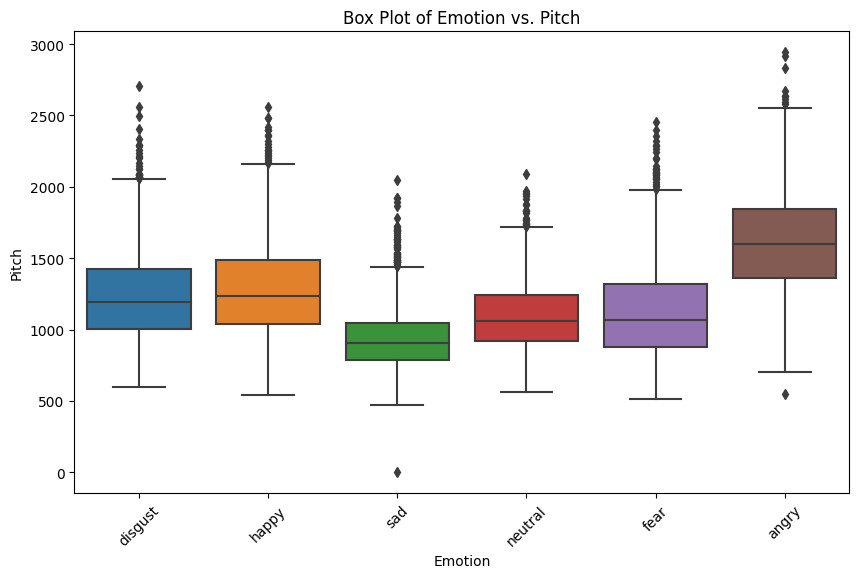

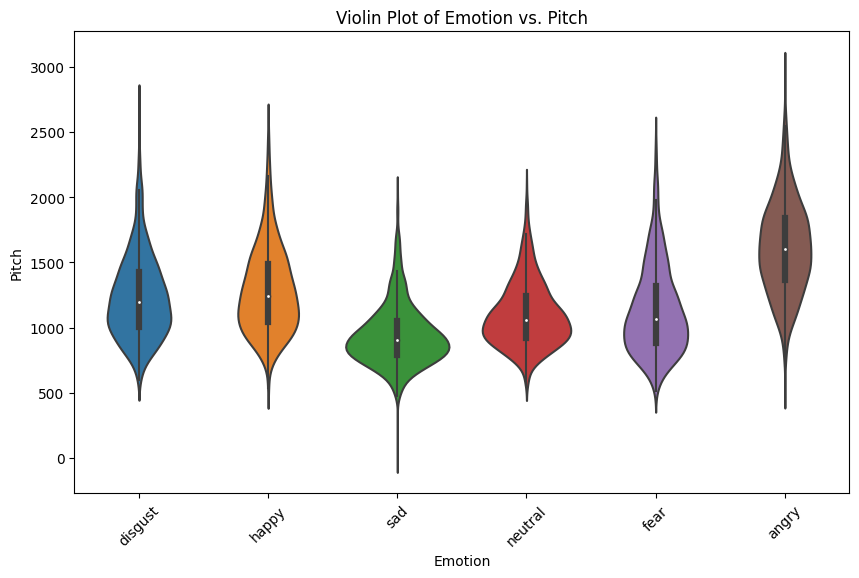

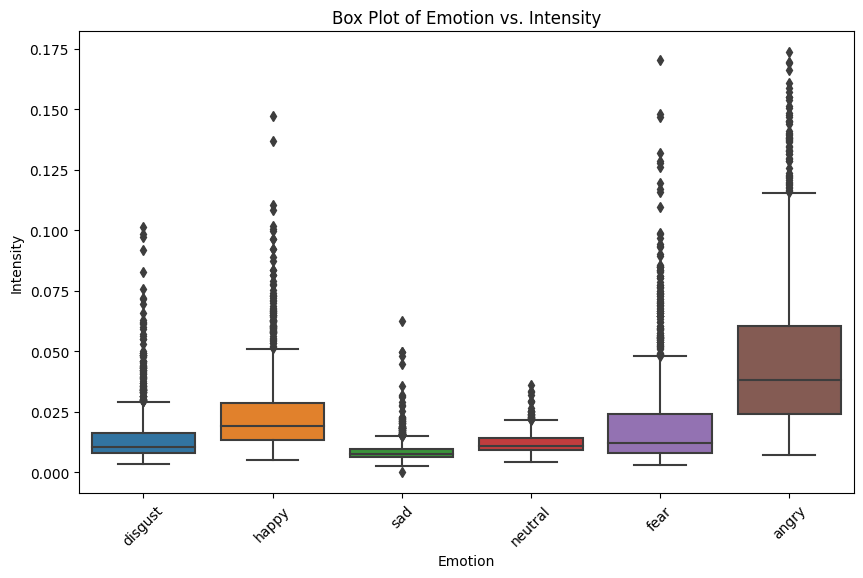

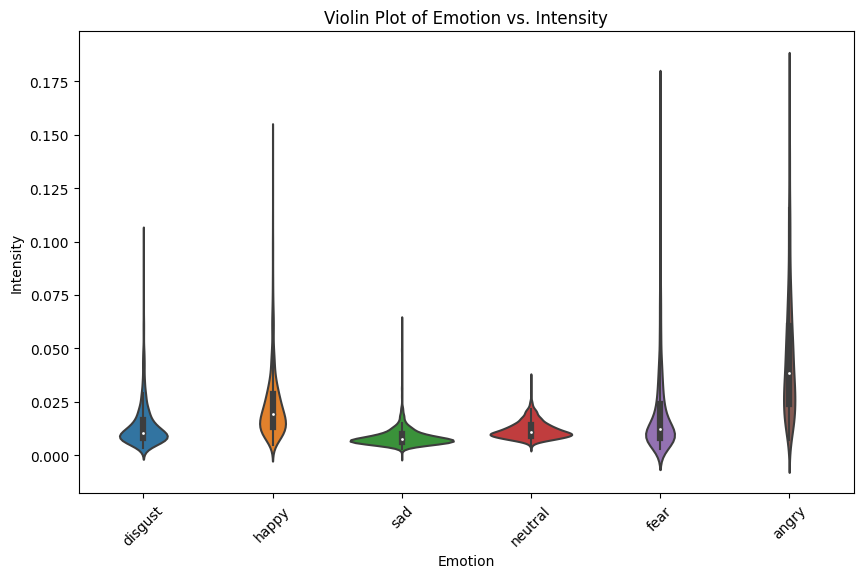

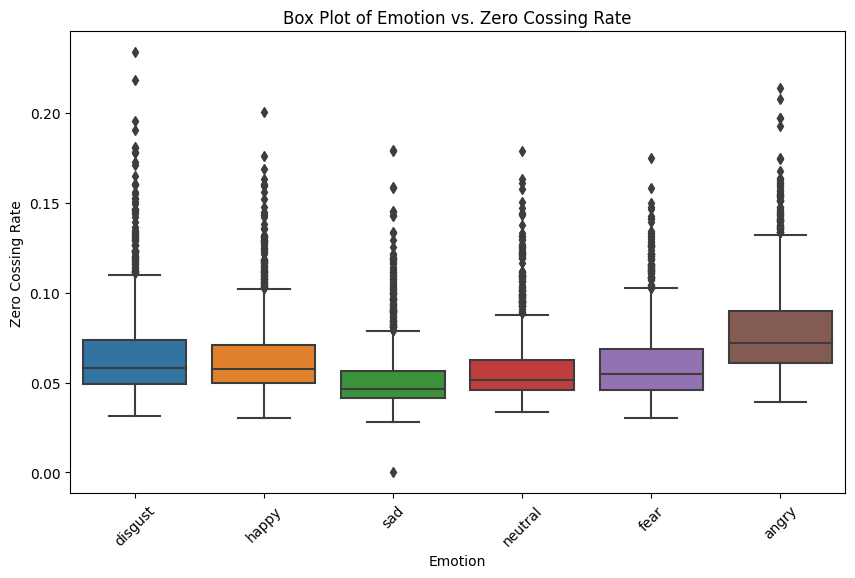

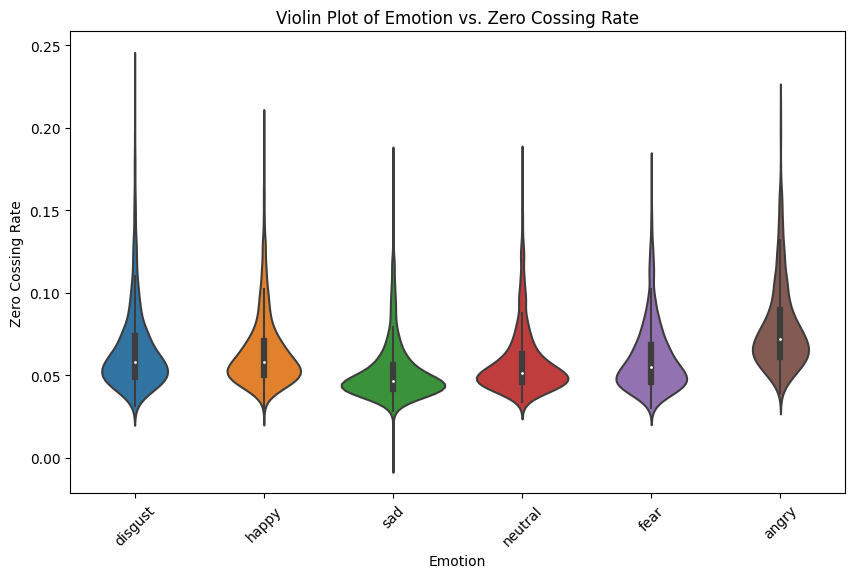

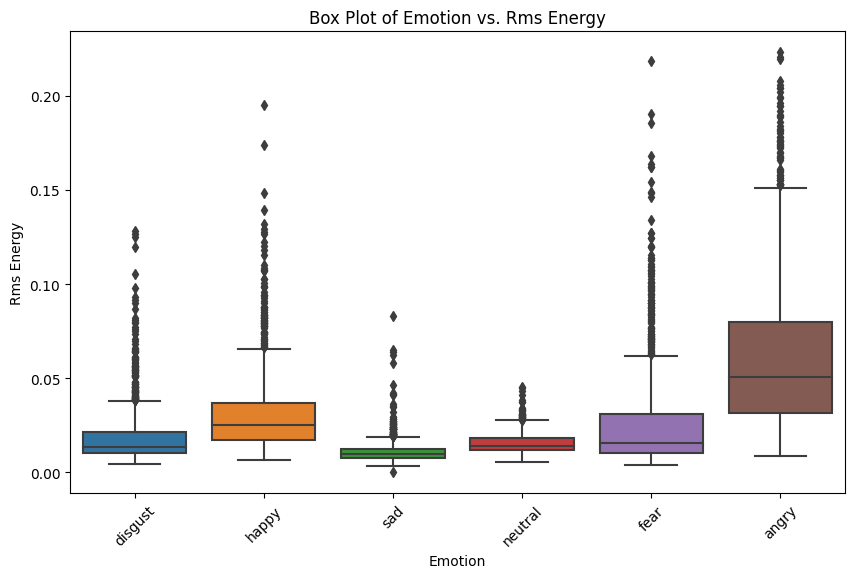

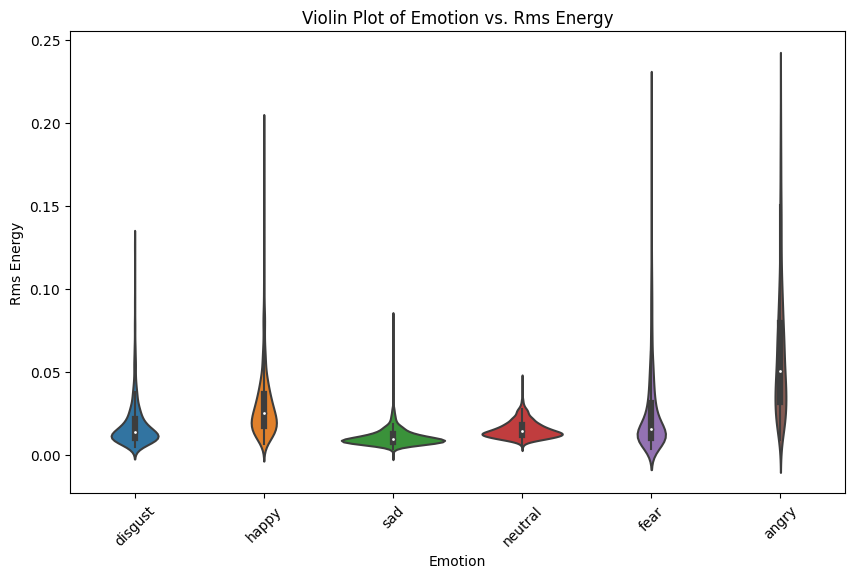

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the CSV file into a DataFrame
data = pd.read_csv('/kaggle/working/ExtractedFeaturesForCremaDatasetLibrosaCleanedNa.csvv')

# Plotting box plot for "Emotion" against "kurtosis"
plt.figure(figsize=(10, 6))
sns.boxplot(x='Emotions', y='kurtosis', data=data)
plt.title('Box Plot of Emotion vs. Kurtosis')
plt.xlabel('Emotion')
plt.ylabel('Kurtosis')
plt.xticks(rotation=45)
plt.show()
# Plotting violin plot for "Emotion" against "kurtosis"
plt.figure(figsize=(10, 6))
sns.violinplot(x='Emotions', y='kurtosis', data=data)
plt.title('Violin Plot of Emotion vs. Kurtosis')
plt.xlabel('Emotions')
plt.ylabel('Kurtosis')
plt.xticks(rotation=45)
plt.show()

# Plotting box plot for "Emotion" against "kurtosis"
plt.figure(figsize=(10, 6))
sns.boxplot(x='Emotions', y='mean', data=data)
plt.title('Box Plot of Emotion vs. Mean')
plt.xlabel('Emotion')
plt.ylabel('Mean')
plt.xticks(rotation=45)
plt.show()
# Plotting violin plot for "Emotion" against "kurtosis"
plt.figure(figsize=(10, 6))
sns.violinplot(x='Emotions', y='mean', data=data)
plt.title('Violin Plot of Emotion vs. Mean')
plt.xlabel('Emotion')
plt.ylabel('Mean')
plt.xticks(rotation=45)
plt.show()


# Plotting box plot for "Emotion" against "kurtosis"
plt.figure(figsize=(10, 6))
sns.boxplot(x='Emotions', y='variance', data=data)
plt.title('Box Plot of Emotion vs. Variance')
plt.xlabel('Emotion')
plt.ylabel('Variance')
plt.xticks(rotation=45)
plt.show()
# Plotting violin plot for "Emotion" against "kurtosis"
plt.figure(figsize=(10, 6))
sns.violinplot(x='Emotions', y='variance', data=data)
plt.title('Violin Plot of Emotion vs. Variance')
plt.xlabel('Emotion')
plt.ylabel('Variance')
plt.xticks(rotation=45)
plt.show()


# Plotting box plot for "Emotion" against "kurtosis"
plt.figure(figsize=(10, 6))
sns.boxplot(x='Emotions', y='skewness', data=data)
plt.title('Box Plot of Emotion vs. Skewness')
plt.xlabel('Emotion')
plt.ylabel('Skewness')
plt.xticks(rotation=45)
plt.show()
# Plotting violin plot for "Emotion" against "kurtosis"
plt.figure(figsize=(10, 6))
sns.violinplot(x='Emotions', y='skewness', data=data)
plt.title('Violin Plot of Emotion vs. Skewness')
plt.xlabel('Emotion')
plt.ylabel('Skewness')
plt.xticks(rotation=45)
plt.show()

# Plotting box plot for "Emotion" against "kurtosis"
plt.figure(figsize=(10, 6))
sns.boxplot(x='Emotions', y='pitch', data=data)
plt.title('Box Plot of Emotion vs. Pitch')
plt.xlabel('Emotion')
plt.ylabel('Pitch')
plt.xticks(rotation=45)
plt.show()
# Plotting violin plot for "Emotion" against "kurtosis"
plt.figure(figsize=(10, 6))
sns.violinplot(x='Emotions', y='pitch', data=data)
plt.title('Violin Plot of Emotion vs. Pitch')
plt.xlabel('Emotion')
plt.ylabel('Pitch')
plt.xticks(rotation=45)
plt.show()

# Plotting box plot for "Emotion" against "kurtosis"
plt.figure(figsize=(10, 6))
sns.boxplot(x='Emotions', y='intensity', data=data)
plt.title('Box Plot of Emotion vs. Intensity')
plt.xlabel('Emotion')
plt.ylabel('Intensity')
plt.xticks(rotation=45)
plt.show()
# Plotting violin plot for "Emotion" against "kurtosis"
plt.figure(figsize=(10, 6))
sns.violinplot(x='Emotions', y='intensity', data=data)
plt.title('Violin Plot of Emotion vs. Intensity')
plt.xlabel('Emotion')
plt.ylabel('Intensity')
plt.xticks(rotation=45)
plt.show()

# Plotting box plot for "Emotion" against "kurtosis"
plt.figure(figsize=(10, 6))
sns.boxplot(x='Emotions', y='zero_crossing_rate', data=data)
plt.title('Box Plot of Emotion vs. Zero Cossing Rate')
plt.xlabel('Emotion')
plt.ylabel('Zero Cossing Rate')
plt.xticks(rotation=45)
plt.show()
# Plotting violin plot for "Emotion" against "kurtosis"
plt.figure(figsize=(10, 6))
sns.violinplot(x='Emotions', y='zero_crossing_rate', data=data)
plt.title('Violin Plot of Emotion vs. Zero Cossing Rate')
plt.xlabel('Emotion')
plt.ylabel('Zero Cossing Rate')
plt.xticks(rotation=45)
plt.show()

# Plotting box plot for "Emotion" against "kurtosis"
plt.figure(figsize=(10, 6))
sns.boxplot(x='Emotions', y='rms_energy', data=data)
plt.title('Box Plot of Emotion vs. Rms Energy')
plt.xlabel('Emotion')
plt.ylabel('Rms Energy')
plt.xticks(rotation=45)
plt.show()
# Plotting violin plot for "Emotion" against "kurtosis"
plt.figure(figsize=(10, 6))
sns.violinplot(x='Emotions', y='rms_energy', data=data)
plt.title('Violin Plot of Emotion vs. Rms Energy')
plt.xlabel('Emotion')
plt.ylabel('Rms Energy')
plt.xticks(rotation=45)
plt.show()

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
import time
import xgboost as xgb
import lightgbm as lgb

# Load data from CSV
data = pd.read_csv('/kaggle/working/ExtractedFeaturesForCremaDatasetLibrosaCleanedNa.csvv')

# Separate features (X) and labels (y)
X = data.drop(columns=['Emotions'])
y = data['Emotions']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Splitting the dataset into train and test sets
X_train, X_test, y_train_encoded, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for CNN input
X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Initializing models
models = {
    'Logistic Regression': LogisticRegression(),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': xgb.XGBClassifier(),
    'LightGBM': lgb.LGBMClassifier(),
    'Feedforward Neural Network': Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(32, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ]),
    'Convolutional Neural Network': Sequential([
        Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ]),
    'Deep Belief Network': Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(len(label_encoder.classes_), activation='softmax')
    ])
}

# Initialize base models
base_models = [
    ('Logistic Regression', LogisticRegression()),
    ('Naive Bayes', GaussianNB()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('KNN', KNeighborsClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('XGBoost', xgb.XGBClassifier()),
    ('LightGBM', lgb.LGBMClassifier())
]

# Initialize ensemble methods
ensemble_methods = {
    'Voting Classifier': VotingClassifier(estimators=base_models),
    'Stacking Classifier': StackingClassifier(estimators=base_models, final_estimator=LogisticRegression()),
    'Bagging Classifier': BaggingClassifier(base_estimator=DecisionTreeClassifier())
}

# Include ensemble methods in the models dictionary
models.update(ensemble_methods)

# Training and evaluating each model
for name, model in models.items():
    start_time = time.time()
    
    if name == 'Feedforward Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_scaled, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    elif name == 'Convolutional Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_cnn, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    elif name == 'Deep Belief Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_scaled, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    else:
        model.fit(X_train, y_train_encoded)
    
    train_time = time.time() - start_time
    
    start_time = time.time()
    if name in ['Feedforward Neural Network', 'Convolutional Neural Network', 'Deep Belief Network']:
        y_pred_proba = model.predict(X_test_scaled)
        y_pred = y_pred_proba.argmax(axis=-1)
    else:
        y_pred = model.predict(X_test)
    
    predict_time = time.time() - start_time
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f'{name}: Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}, Training Time = {train_time:.4f} s, Prediction Time = {predict_time:.4f} s')


Logistic Regression: Accuracy = 0.3694, Precision = 0.3632, Recall = 0.3694, F1 Score = 0.3472, Training Time = 3.2753 s, Prediction Time = 0.0589 s
Naive Bayes: Accuracy = 0.3660, Precision = 0.4018, Recall = 0.3660, F1 Score = 0.3372, Training Time = 0.3292 s, Prediction Time = 0.1009 s
Decision Tree: Accuracy = 0.3217, Precision = 0.3205, Recall = 0.3217, F1 Score = 0.3209, Training Time = 12.0937 s, Prediction Time = 0.0307 s
Random Forest: Accuracy = 0.4238, Precision = 0.4012, Recall = 0.4238, F1 Score = 0.4012, Training Time = 23.3002 s, Prediction Time = 0.1110 s
KNN: Accuracy = 0.2901, Precision = 0.3062, Recall = 0.2901, F1 Score = 0.2873, Training Time = 0.1184 s, Prediction Time = 0.6747 s
Gradient Boosting: Accuracy = 0.4647, Precision = 0.4579, Recall = 0.4647, F1 Score = 0.4573, Training Time = 1722.1660 s, Prediction Time = 0.0633 s
XGBoost: Accuracy = 0.4621, Precision = 0.4526, Recall = 0.4621, F1 Score = 0.4517, Training Time = 282.0845 s, Prediction Time = 0.3131 s


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
import time
import xgboost as xgb
import lightgbm as lgb

# Load data from CSV
data = pd.read_csv('/kaggle/working/ExtractedFeaturesForCremaDatasetLibrosaCleanedNa.csvv')

# Separate features (X) and labels (y)
X = data.drop(columns=['Emotions'])
y = data['Emotions']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Splitting the dataset into train and test sets
X_train, X_test, y_train_encoded, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

from sklearn.preprocessing import RobustScaler

# Robust scaler for handling outliers
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Reshape data for CNN input
X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Initializing models
models = {
    'Logistic Regression': LogisticRegression(),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': xgb.XGBClassifier(),
    'LightGBM': lgb.LGBMClassifier(),
    'Feedforward Neural Network': Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(32, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ]),
    'Convolutional Neural Network': Sequential([
        Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ]),
    'Deep Belief Network': Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(len(label_encoder.classes_), activation='softmax')
    ])
}

# Initialize base models
base_models = [
    ('Logistic Regression', LogisticRegression()),
    ('Naive Bayes', GaussianNB()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('KNN', KNeighborsClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('XGBoost', xgb.XGBClassifier()),
    ('LightGBM', lgb.LGBMClassifier())
]

# Initialize ensemble methods
ensemble_methods = {
    'Voting Classifier': VotingClassifier(estimators=base_models),
    'Stacking Classifier': StackingClassifier(estimators=base_models, final_estimator=LogisticRegression()),
    'Bagging Classifier': BaggingClassifier(base_estimator=DecisionTreeClassifier())
}

# Include ensemble methods in the models dictionary
models.update(ensemble_methods)

# Training and evaluating each model
for name, model in models.items():
    start_time = time.time()
    
    if name == 'Feedforward Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_scaled, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    elif name == 'Convolutional Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_cnn, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    elif name == 'Deep Belief Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_scaled, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    else:
        model.fit(X_train, y_train_encoded)
    
    train_time = time.time() - start_time
    
    start_time = time.time()
    if name in ['Feedforward Neural Network', 'Convolutional Neural Network', 'Deep Belief Network']:
        y_pred_proba = model.predict(X_test_scaled)
        y_pred = y_pred_proba.argmax(axis=-1)
    else:
        y_pred = model.predict(X_test)
    
    predict_time = time.time() - start_time
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f'{name}: Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}, Training Time = {train_time:.4f} s, Prediction Time = {predict_time:.4f} s')


Logistic Regression: Accuracy = 0.3694, Precision = 0.3632, Recall = 0.3694, F1 Score = 0.3472, Training Time = 3.0676 s, Prediction Time = 0.0412 s
Naive Bayes: Accuracy = 0.3660, Precision = 0.4018, Recall = 0.3660, F1 Score = 0.3372, Training Time = 0.2804 s, Prediction Time = 0.1386 s
Decision Tree: Accuracy = 0.3156, Precision = 0.3132, Recall = 0.3156, F1 Score = 0.3139, Training Time = 12.0809 s, Prediction Time = 0.0230 s
Random Forest: Accuracy = 0.4285, Precision = 0.4015, Recall = 0.4285, F1 Score = 0.4050, Training Time = 22.9618 s, Prediction Time = 0.1047 s
KNN: Accuracy = 0.2901, Precision = 0.3062, Recall = 0.2901, F1 Score = 0.2873, Training Time = 0.0913 s, Prediction Time = 0.5956 s
Gradient Boosting: Accuracy = 0.4647, Precision = 0.4580, Recall = 0.4647, F1 Score = 0.4575, Training Time = 1720.3580 s, Prediction Time = 0.0813 s
XGBoost: Accuracy = 0.4621, Precision = 0.4526, Recall = 0.4621, F1 Score = 0.4517, Training Time = 282.9373 s, Prediction Time = 0.2423 s


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
import time
import xgboost as xgb
import lightgbm as lgb

# Load data from CSV
data = pd.read_csv('/kaggle/input/cremalibrosaextracted/ExtractedFeaturesForCremaDatasetLibrosaCleanedNa.csv')

# Separate features (X) and labels (y)
X = data.drop(columns=['Emotions'])
y = data['Emotions']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Splitting the dataset into train and test sets
X_train, X_test, y_train_encoded, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

from sklearn.preprocessing import MinMaxScaler

# MinMax scaler for scaling features to a range
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



# Reshape data for CNN input
X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Initializing models
models = {
    'Logistic Regression': LogisticRegression(),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': xgb.XGBClassifier(),
    'LightGBM': lgb.LGBMClassifier(),
    'Feedforward Neural Network': Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(32, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ]),
    'Convolutional Neural Network': Sequential([
        Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ]),
    'Deep Belief Network': Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(len(label_encoder.classes_), activation='softmax')
    ])
}

# Initialize base models
base_models = [
    ('Logistic Regression', LogisticRegression()),
    ('Naive Bayes', GaussianNB()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('KNN', KNeighborsClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('XGBoost', xgb.XGBClassifier()),
    ('LightGBM', lgb.LGBMClassifier())
]

# Initialize ensemble methods
ensemble_methods = {
    'Voting Classifier': VotingClassifier(estimators=base_models),
    'Stacking Classifier': StackingClassifier(estimators=base_models, final_estimator=LogisticRegression()),
    'Bagging Classifier': BaggingClassifier(base_estimator=DecisionTreeClassifier())
}

# Include ensemble methods in the models dictionary
models.update(ensemble_methods)

# Training and evaluating each model
for name, model in models.items():
    start_time = time.time()
    
    if name == 'Feedforward Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_scaled, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    elif name == 'Convolutional Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_cnn, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    elif name == 'Deep Belief Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_scaled, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    else:
        model.fit(X_train, y_train_encoded)
    
    train_time = time.time() - start_time
    
    start_time = time.time()
    if name in ['Feedforward Neural Network', 'Convolutional Neural Network', 'Deep Belief Network']:
        y_pred_proba = model.predict(X_test_scaled)
        y_pred = y_pred_proba.argmax(axis=-1)
    else:
        y_pred = model.predict(X_test)
    
    predict_time = time.time() - start_time
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f'{name}: Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}, Training Time = {train_time:.4f} s, Prediction Time = {predict_time:.4f} s')


2024-04-22 14:19:12.525821: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-22 14:19:12.525995: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-22 14:19:12.671846: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-pac

Logistic Regression: Accuracy = 0.3694, Precision = 0.3632, Recall = 0.3694, F1 Score = 0.3472, Training Time = 3.1698 s, Prediction Time = 0.0597 s
Naive Bayes: Accuracy = 0.3660, Precision = 0.4018, Recall = 0.3660, F1 Score = 0.3372, Training Time = 0.3949 s, Prediction Time = 0.1534 s
Decision Tree: Accuracy = 0.3271, Precision = 0.3270, Recall = 0.3271, F1 Score = 0.3269, Training Time = 12.0868 s, Prediction Time = 0.0329 s
Random Forest: Accuracy = 0.4184, Precision = 0.3829, Recall = 0.4184, F1 Score = 0.3898, Training Time = 23.3146 s, Prediction Time = 0.1000 s
KNN: Accuracy = 0.2901, Precision = 0.3062, Recall = 0.2901, F1 Score = 0.2873, Training Time = 0.1383 s, Prediction Time = 0.5989 s
Gradient Boosting: Accuracy = 0.4634, Precision = 0.4564, Recall = 0.4634, F1 Score = 0.4561, Training Time = 1709.5834 s, Prediction Time = 0.0797 s
XGBoost: Accuracy = 0.4621, Precision = 0.4526, Recall = 0.4621, F1 Score = 0.4517, Training Time = 283.2889 s, Prediction Time = 0.2496 s


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Convolutional Neural Network: Accuracy = 0.3929, Precision = 0.4133, Recall = 0.3929, F1 Score = 0.3618, Training Time = 67.2560 s, Prediction Time = 0.6988 s
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Deep Belief Network: Accuracy = 0.3324, Precision = 0.1963, Recall = 0.3324, F1 Score = 0.2278, Training Time = 6.5043 s, Prediction Time = 0.3765 s


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.296892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 348082
[LightGBM] [Info] Number of data points in the train set: 5953, number of used features: 1444
[LightGBM] [Info] Start training from score -1.761156
[LightGBM] [Info] Start training from score -1.781897
[LightGBM] [Info] Start training from score -1.757253
[LightGBM] [Info] Start training from score -1.769007
[LightGBM] [Info] Start training from score -1.928921
[LightGBM] [Info] Start training from score -1.763113
Voting Classifier: Accuracy = 0.4567, Precision = 0.4455, Recall = 0.4567, F1 Score = 0.4426, Training Time = 2233.5620 s, Prediction Time = 1.8066 s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.281626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 348082
[LightGBM] [Info] Number of data points in the train set: 5953, number of used features: 1444
[LightGBM] [Info] Start training from score -1.761156
[LightGBM] [Info] Start training from score -1.781897
[LightGBM] [Info] Start training from score -1.757253
[LightGBM] [Info] Start training from score -1.769007
[LightGBM] [Info] Start training from score -1.928921
[LightGBM] [Info] Start training from score -1.763113


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from sklearn.decomposition import PCA
import time
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Load data from CSV
data = pd.read_csv('/kaggle/input/cremalibrosaextracted/ExtractedFeaturesForCremaDatasetLibrosaCleanedNa.csv')

# Separate features (X) and labels (y)
X = data.drop(columns=['Emotions'])
y = data['Emotions']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Splitting the dataset into train and test sets
X_train, X_test, y_train_encoded, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Scale features using RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize PCA
pca = PCA(n_components=0.95)  # Retain 95% of the variance

# Fit PCA on the training data and transform both training and test data
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Display the number of components retained after PCA
print(f'Number of components retained after PCA: {pca.n_components_}')

# Reshape data for CNN input after PCA
X_train_pca_cnn = X_train_pca.reshape(X_train_pca.shape[0], X_train_pca.shape[1], 1)
X_test_pca_cnn = X_test_pca.reshape(X_test_pca.shape[0], X_test_pca.shape[1], 1)

# Initializing models
models = {
    'Logistic Regression': LogisticRegression(C=1.0, penalty='l2'),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(max_depth=5),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=5),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1),
    'XGBoost': XGBClassifier(n_estimators=100, max_depth=5, objective='multi:softmax'),
    'LightGBM': LGBMClassifier(n_estimators=100, max_depth=5, objective='multiclass'),
    'Feedforward Neural Network': Sequential([
        Dense(128, activation='relu', input_shape=(X_train_pca.shape[1],)),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ]),
    'Convolutional Neural Network': Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_pca_cnn.shape[1], X_train_pca_cnn.shape[2])),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ]),
    'Deep Belief Network': Sequential([
        Dense(128, activation='relu', input_shape=(X_train_pca.shape[1],)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ]),
    'SVM': SVC(kernel='linear')
}

# Initialize base models
base_models = [
    ('Logistic Regression', LogisticRegression(C=1.0, penalty='l2')),
    ('Naive Bayes', GaussianNB()),
    ('Decision Tree', DecisionTreeClassifier(max_depth=5)),
    ('Random Forest', RandomForestClassifier(n_estimators=100, max_depth=5)),
    ('KNN', KNeighborsClassifier(n_neighbors=5)),
    ('Gradient Boosting', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1))
]

# Initialize ensemble methods
ensemble_methods = {
    'Voting Classifier': VotingClassifier(estimators=base_models),
    'Stacking Classifier': StackingClassifier(estimators=base_models, final_estimator=LogisticRegression()),
    'Bagging Classifier': BaggingClassifier(base_estimator=DecisionTreeClassifier())
}

# Include ensemble methods in the models dictionary
models.update(ensemble_methods)

# Training and evaluating each model with PCA-transformed data
for name, model in models.items():
    start_time = time.time()
    
    if name == 'Feedforward Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_pca, y_train_encoded, epochs=20, batch_size=64, verbose=0)
    elif name == 'Convolutional Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_pca_cnn, y_train_encoded, epochs=20, batch_size=64, verbose=0)
    elif name == 'Deep Belief Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_pca, y_train_encoded, epochs=20, batch_size=64, verbose=0)
    else:
        model.fit(X_train_pca, y_train_encoded)
    
    train_time = time.time() - start_time
    
    start_time = time.time()
    if name in ['Feedforward Neural Network', 'Convolutional Neural Network', 'Deep Belief Network']:
        y_pred_proba = model.predict(X_test_pca)
        y_pred = y_pred_proba.argmax(axis=-1)
    else:
        y_pred = model.predict(X_test_pca)
    
    predict_time = time.time() - start_time
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f'{name} with PCA: Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}, Training Time = {train_time:.4f} s, Prediction Time = {predict_time:.4f} s')


2024-05-05 03:17:08.112697: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-05 03:17:08.112898: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-05 03:17:08.269185: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Number of components retained after PCA: 128


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative s

Logistic Regression with PCA: Accuracy = 0.3036, Precision = 0.2853, Recall = 0.3036, F1 Score = 0.2820, Training Time = 0.8480 s, Prediction Time = 0.0016 s
Naive Bayes with PCA: Accuracy = 0.3150, Precision = 0.3229, Recall = 0.3150, F1 Score = 0.2831, Training Time = 0.0265 s, Prediction Time = 0.0112 s


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Decision Tree with PCA: Accuracy = 0.3143, Precision = 0.2371, Recall = 0.3143, F1 Score = 0.2486, Training Time = 0.5656 s, Prediction Time = 0.0008 s


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest with PCA: Accuracy = 0.3613, Precision = 0.3479, Recall = 0.3613, F1 Score = 0.2713, Training Time = 3.2841 s, Prediction Time = 0.0236 s
KNN with PCA: Accuracy = 0.2512, Precision = 0.2842, Recall = 0.2512, F1 Score = 0.2128, Training Time = 0.0048 s, Prediction Time = 0.2341 s
Gradient Boosting with PCA: Accuracy = 0.3788, Precision = 0.3565, Recall = 0.3788, F1 Score = 0.3620, Training Time = 175.1324 s, Prediction Time = 0.0206 s
XGBoost with PCA: Accuracy = 0.3781, Precision = 0.3563, Recall = 0.3781, F1 Score = 0.3601, Training Time = 17.5975 s, Prediction Time = 0.0227 s
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018079 seconds.
You can set `force_col_wise=true` to 

KeyboardInterrupt: 

# WAV2VEC FEATURES

In [1]:
import os
import torch
import torch.nn as nn
import pandas as pd
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import torchaudio
from torchaudio.transforms import Resample
import numpy as np
import time

class EmotionModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.wav2vec2 = Wav2Vec2Model(config)

    def forward(self, input_values):
        outputs = self.wav2vec2(input_values)
        hidden_states = outputs.last_hidden_state.squeeze().mean(axis=0)
        return hidden_states

def process_func(audio_dir):
    device = 'cpu'
    model_name = 'audeering/wav2vec2-large-robust-12-ft-emotion-msp-dim'
    processor = Wav2Vec2Processor.from_pretrained(model_name)
    model = Wav2Vec2Model.from_pretrained(model_name)
    model.to(device)

    features_list = []
    paths_list = []

    resampler = Resample(orig_freq=24414, new_freq=16000)

    start_time = time.time()

    for root, dirs, files in os.walk(audio_dir):
        for file in files:
            audio_path = os.path.join(root, file)
            array, fs = torchaudio.load(audio_path)
            array_resampled = resampler(array)
            input_values = processor(array_resampled.squeeze(), sampling_rate=16000, return_tensors="pt")
            input_values = input_values.input_values.to(device)
            with torch.no_grad():
                hidden_states = model(input_values)
            features_list.append(hidden_states.last_hidden_state.squeeze().mean(axis=0).cpu().numpy().tolist())
            paths_list.append(audio_path)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Time taken to extract features:", elapsed_time, "seconds")

    return features_list, paths_list

# Example usage:
audio_dir = '/kaggle/input/cremad/AudioWAV/'
features_list, paths_list = process_func(audio_dir)

# Convert lists to DataFrame
data = {'Path': paths_list}
for i in range(len(features_list[0])):
    data[f'Feature_{i}'] = [feature[i] for feature in features_list]

df = pd.DataFrame(data)

# Save DataFrame to CSV
csv_file = '/kaggle/working/featuresforCremadWav2vec.csv'
df.to_csv(csv_file, index=False)
print("Features saved to:", csv_file)


preprocessor_config.json:   0%|          | 0.00/214 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/661M [00:00<?, ?B/s]

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at audeering/wav2vec2-large-robust-12-ft-emotion-msp-dim and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2024-04-26 17:39:57.835262: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-26 17:39:57.835414: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-26 17:39:57.991750: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory

Time taken to extract features: 6101.162845134735 seconds
Features saved to: /kaggle/working/featuresforCremadWav2vec.csv


In [6]:
data = pd.read_csv('/kaggle/working/featuresforCremadWav2vec.csv')
data.tail
#31 mis

<bound method NDFrame.tail of                                                    Path  Feature_0  Feature_1  \
0     /kaggle/input/cremad/AudioWAV/1028_TSI_DIS_XX.wav  -0.007656   0.006735   
1     /kaggle/input/cremad/AudioWAV/1075_IEO_HAP_LO.wav  -0.007408   0.006068   
2     /kaggle/input/cremad/AudioWAV/1084_ITS_HAP_XX.wav  -0.007376   0.005763   
3     /kaggle/input/cremad/AudioWAV/1067_IWW_DIS_XX.wav  -0.007149   0.006517   
4     /kaggle/input/cremad/AudioWAV/1066_TIE_DIS_XX.wav  -0.007336   0.006951   
...                                                 ...        ...        ...   
7437  /kaggle/input/cremad/AudioWAV/1060_IEO_ANG_MD.wav  -0.007578   0.005734   
7438  /kaggle/input/cremad/AudioWAV/1088_IWL_ANG_XX.wav  -0.007753   0.006092   
7439  /kaggle/input/cremad/AudioWAV/1050_IOM_ANG_XX.wav  -0.007379   0.006399   
7440  /kaggle/input/cremad/AudioWAV/1044_IWL_SAD_XX.wav  -0.007575   0.005106   
7441  /kaggle/input/cremad/AudioWAV/1009_ITH_SAD_XX.wav  -0.007672   0.005620  

In [3]:
import pandas as pd

# Read the CSV file into a DataFrame
csv_file = '/kaggle/working/featuresforCremadWav2vec.csv'
df = pd.read_csv(csv_file)

# Get the number of rows and columns
num_rows, num_cols = df.shape

# Print the number of rows and columns
print("Number of rows:", num_rows)
print("Number of columns:", num_cols)


Number of rows: 7442
Number of columns: 1025


In [4]:
import pandas as pd

# Read the first CSV file
csv1 = pd.read_csv("/kaggle/input/cremalibrosaextracted/ExtractedFeaturesForCremaDatasetLibrosaCleanedNa.csv")

# Read the second CSV file
csv2 = pd.read_csv("/kaggle/working/featuresforCremadWav2vec.csv")

# Copy the 'Emotions' column from csv1 to csv2
csv2['Emotions'] = csv1['Emotions']

# Save the modified csv2 to a new CSV file
csv2.to_csv("/kaggle/working/ExtractedFeaturesForCremaDatasetWav2Vec.csv", index=False)

print("Emotions column copied from csv1 to csv2 and saved to output.csv")


Emotions column copied from csv1 to csv2 and saved to output.csv


In [5]:
import pandas as pd

# Read the CSV file into a DataFrame
csv_file_path = "/kaggle/working/ExtractedFeaturesForCremaDatasetWav2Vec.csv"
data = pd.read_csv(csv_file_path)

# Print a particular column (e.g., "emotion")
print(data["Emotions"])


0       disgust
1         happy
2         happy
3       disgust
4       disgust
         ...   
7437      angry
7438      angry
7439      angry
7440        sad
7441        sad
Name: Emotions, Length: 7442, dtype: object


stadard scaler, default parameters

In [2]:

import pandas as pd

# Read the CSV file into a DataFrame
df = pd.read_csv("/kaggle/input/wav2veccremaextracted/ExtractedFeaturesForCremaDatasetWav2Vec.csv")

# Drop the desired column (change 'column_to_drop' to the name of the column you want to drop)
df.drop(columns=['Path'], inplace=True)

# Save the updated DataFrame back to the same CSV file
df.to_csv("Wav2VecExtractedFeaturesForCremaDataset.csv", index=False)

print("Column dropped and CSV file updated successfully.")


Column dropped and CSV file updated successfully.


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
import time

# Load data from CSV
data = pd.read_csv('/kaggle/working/Wav2VecExtractedFeaturesForCremaDataset.csv')

# Separate features (X) and labels (y)
X = data.drop(columns=['Emotions'])
y = data['Emotions']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Splitting the dataset into train and test sets
X_train, X_test, y_train_encoded, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for CNN input
X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Initializing models
models = {
    'Logistic Regression': LogisticRegression(),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Feedforward Neural Network': Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(32, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ]),
    'Convolutional Neural Network': Sequential([
        Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ]),
    'Deep Belief Network': Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(len(label_encoder.classes_), activation='softmax')
    ])
}

# Initialize base models
base_models = [
    ('Logistic Regression', LogisticRegression()),
    ('Naive Bayes', GaussianNB()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('KNN', KNeighborsClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier())
]

# Initialize ensemble methods
ensemble_methods = {
    'Voting Classifier': VotingClassifier(estimators=base_models),
    'Stacking Classifier': StackingClassifier(estimators=base_models, final_estimator=LogisticRegression()),
    'Bagging Classifier': BaggingClassifier(base_estimator=DecisionTreeClassifier())
}

# Include ensemble methods in the models dictionary
models.update(ensemble_methods)

# Training and evaluating each model
for name, model in models.items():
    start_time = time.time()
    
    if name == 'Feedforward Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_scaled, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    elif name == 'Convolutional Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_cnn, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    elif name == 'Deep Belief Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_scaled, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    else:
        model.fit(X_train, y_train_encoded)
    
    train_time = time.time() - start_time
    
    start_time = time.time()
    if name in ['Feedforward Neural Network', 'Convolutional Neural Network', 'Deep Belief Network']:
        y_pred_proba = model.predict(X_test_scaled)
        y_pred = y_pred_proba.argmax(axis=-1)
    else:
        y_pred = model.predict(X_test)
    
    predict_time = time.time() - start_time
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f'{name}: Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}, Training Time = {train_time:.4f} s, Prediction Time = {predict_time:.4f} s')


2024-04-28 09:22:43.036046: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-28 09:22:43.036169: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-28 09:22:43.193085: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-pac

Logistic Regression: Accuracy = 0.5850, Precision = 0.5809, Recall = 0.5850, F1 Score = 0.5811, Training Time = 1.8937 s, Prediction Time = 0.0736 s
Naive Bayes: Accuracy = 0.4426, Precision = 0.4369, Recall = 0.4426, F1 Score = 0.4164, Training Time = 0.1745 s, Prediction Time = 0.0785 s
Decision Tree: Accuracy = 0.3499, Precision = 0.3473, Recall = 0.3499, F1 Score = 0.3482, Training Time = 8.7460 s, Prediction Time = 0.0200 s
Random Forest: Accuracy = 0.5285, Precision = 0.5227, Recall = 0.5285, F1 Score = 0.5162, Training Time = 18.9548 s, Prediction Time = 0.0842 s
KNN: Accuracy = 0.4587, Precision = 0.4489, Recall = 0.4587, F1 Score = 0.4443, Training Time = 0.0609 s, Prediction Time = 0.4499 s
Gradient Boosting: Accuracy = 0.5615, Precision = 0.5589, Recall = 0.5615, F1 Score = 0.5585, Training Time = 1335.8269 s, Prediction Time = 0.0539 s
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Feedforward Neural Network: Accuracy = 0.6017, Precision = 0.6049, Recall = 0.6017, F1 Score = 0.6028

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Voting Classifier: Accuracy = 0.5520, Precision = 0.5458, Recall = 0.5520, F1 Score = 0.5423, Training Time = 1359.6522 s, Prediction Time = 0.6914 s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Stacking Classifier: Accuracy = 0.5937, Precision = 0.5907, Recall = 0.5937, F1 Score = 0.5899, Training Time = 6819.1376 s, Prediction Time = 0.7795 s


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Bagging Classifier: Accuracy = 0.4527, Precision = 0.4438, Recall = 0.4527, F1 Score = 0.4463, Training Time = 62.4587 s, Prediction Time = 0.0766 s


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
import time

# Load data from CSV
data = pd.read_csv('/kaggle/working/Wav2VecExtractedFeaturesForCremaDataset.csv')

# Separate features (X) and labels (y)
X = data.drop(columns=['Emotions'])
y = data['Emotions']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Splitting the dataset into train and test sets
X_train, X_test, y_train_encoded, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Scale features using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for CNN input
X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Initializing models
models = {
    'Logistic Regression': LogisticRegression(),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Feedforward Neural Network': Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(32, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ]),
    'Convolutional Neural Network': Sequential([
        Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ]),
    'Deep Belief Network': Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(len(label_encoder.classes_), activation='softmax')
    ])
}

# Initialize base models
base_models = [
    ('Logistic Regression', LogisticRegression(penalty='l2')),
    ('Naive Bayes', GaussianNB()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('KNN', KNeighborsClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier())
]

# Initialize ensemble methods
ensemble_methods = {
    'Voting Classifier': VotingClassifier(estimators=base_models),
    'Stacking Classifier': StackingClassifier(estimators=base_models, final_estimator=LogisticRegression()),
    'Bagging Classifier': BaggingClassifier(base_estimator=DecisionTreeClassifier())
}

# Include ensemble methods in the models dictionary
models.update(ensemble_methods)

# Training and evaluating each model
for name, model in models.items():
    start_time = time.time()
    
    if name == 'Feedforward Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_scaled, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    elif name == 'Convolutional Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_cnn, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    elif name == 'Deep Belief Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_scaled, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    else:
        model.fit(X_train, y_train_encoded)
    
    train_time = time.time() - start_time
    
    start_time = time.time()
    if name in ['Feedforward Neural Network', 'Convolutional Neural Network', 'Deep Belief Network']:
        y_pred_proba = model.predict(X_test_scaled)
        y_pred = y_pred_proba.argmax(axis=-1)
    else:
        y_pred = model.predict(X_test)
    
    predict_time = time.time() - start_time
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f'{name}: Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}, Training Time = {train_time:.4f} s, Prediction Time = {predict_time:.4f} s')


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative s

Logistic Regression: Accuracy = 0.5850, Precision = 0.5809, Recall = 0.5850, F1 Score = 0.5811, Training Time = 1.8525 s, Prediction Time = 0.0354 s
Naive Bayes: Accuracy = 0.4426, Precision = 0.4369, Recall = 0.4426, F1 Score = 0.4164, Training Time = 0.2133 s, Prediction Time = 0.0715 s
Decision Tree: Accuracy = 0.3472, Precision = 0.3465, Recall = 0.3472, F1 Score = 0.3465, Training Time = 8.8007 s, Prediction Time = 0.0200 s
Random Forest: Accuracy = 0.5225, Precision = 0.5158, Recall = 0.5225, F1 Score = 0.5084, Training Time = 19.1707 s, Prediction Time = 0.0905 s
KNN: Accuracy = 0.4587, Precision = 0.4489, Recall = 0.4587, F1 Score = 0.4443, Training Time = 0.0607 s, Prediction Time = 0.4155 s
Gradient Boosting: Accuracy = 0.5615, Precision = 0.5592, Recall = 0.5615, F1 Score = 0.5584, Training Time = 1350.0676 s, Prediction Time = 0.0512 s
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Feedforward Neural Network: Accuracy = 0.5769, Precision = 0.5879, Recall = 0.5769, F1 Score = 0.5725

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Voting Classifier: Accuracy = 0.5500, Precision = 0.5453, Recall = 0.5500, F1 Score = 0.5409, Training Time = 1382.6576 s, Prediction Time = 0.7207 s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Stacking Classifier: Accuracy = 0.5944, Precision = 0.5924, Recall = 0.5944, F1 Score = 0.5914, Training Time = 6792.8304 s, Prediction Time = 0.7919 s


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Bagging Classifier: Accuracy = 0.4560, Precision = 0.4496, Recall = 0.4560, F1 Score = 0.4504, Training Time = 59.4287 s, Prediction Time = 0.0869 s


roust scaler

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
import time

# Load data from CSV
data = pd.read_csv('/kaggle/working/Wav2VecExtractedFeaturesForCremaDataset.csv')

# Separate features (X) and labels (y)
X = data.drop(columns=['Emotions'])
y = data['Emotions']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Splitting the dataset into train and test sets
X_train, X_test, y_train_encoded, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Scale features using RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for CNN input
X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Initializing models
models = {
    'Logistic Regression': LogisticRegression(),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Feedforward Neural Network': Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(32, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ]),
    'Convolutional Neural Network': Sequential([
        Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ]),
    'Deep Belief Network': Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(len(label_encoder.classes_), activation='softmax')
    ])
}

# Initialize base models
base_models = [
    ('Logistic Regression', LogisticRegression(penalty='l2')),
    ('Naive Bayes', GaussianNB()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('KNN', KNeighborsClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier())
]

# Initialize ensemble methods
ensemble_methods = {
    'Voting Classifier': VotingClassifier(estimators=base_models),
    'Stacking Classifier': StackingClassifier(estimators=base_models, final_estimator=LogisticRegression()),
    'Bagging Classifier': BaggingClassifier(base_estimator=DecisionTreeClassifier())
}

# Include ensemble methods in the models dictionary
models.update(ensemble_methods)

# Training and evaluating each model
for name, model in models.items():
    start_time = time.time()
    
    if name == 'Feedforward Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_scaled, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    elif name == 'Convolutional Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_cnn, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    elif name == 'Deep Belief Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_scaled, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    else:
        model.fit(X_train, y_train_encoded)
    
    train_time = time.time() - start_time
    
    start_time = time.time()
    if name in ['Feedforward Neural Network', 'Convolutional Neural Network', 'Deep Belief Network']:
        y_pred_proba = model.predict(X_test_scaled)
        y_pred = y_pred_proba.argmax(axis=-1)
    else:
        y_pred = model.predict(X_test)
    
    predict_time = time.time() - start_time
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f'{name}: Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}, Training Time = {train_time:.4f} s, Prediction Time = {predict_time:.4f} s')


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative s

Logistic Regression: Accuracy = 0.5850, Precision = 0.5809, Recall = 0.5850, F1 Score = 0.5811, Training Time = 1.8531 s, Prediction Time = 0.0348 s
Naive Bayes: Accuracy = 0.4426, Precision = 0.4369, Recall = 0.4426, F1 Score = 0.4164, Training Time = 0.1823 s, Prediction Time = 0.0734 s
Decision Tree: Accuracy = 0.3586, Precision = 0.3571, Recall = 0.3586, F1 Score = 0.3575, Training Time = 8.6584 s, Prediction Time = 0.0201 s
Random Forest: Accuracy = 0.5292, Precision = 0.5214, Recall = 0.5292, F1 Score = 0.5147, Training Time = 18.6303 s, Prediction Time = 0.0846 s
KNN: Accuracy = 0.4587, Precision = 0.4489, Recall = 0.4587, F1 Score = 0.4443, Training Time = 0.0574 s, Prediction Time = 0.4397 s
Gradient Boosting: Accuracy = 0.5608, Precision = 0.5583, Recall = 0.5608, F1 Score = 0.5576, Training Time = 1330.5700 s, Prediction Time = 0.0501 s
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Feedforward Neural Network: Accuracy = 0.6145, Precision = 0.6113, Recall = 0.6145, F1 Score = 0.6120

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Voting Classifier: Accuracy = 0.5561, Precision = 0.5507, Recall = 0.5561, F1 Score = 0.5472, Training Time = 1354.6760 s, Prediction Time = 0.6897 s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


differemt models of LR

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, Dropout
import xgboost as xgb
import lightgbm as lgb
import time

# Load data from CSV
data = pd.read_csv('/kaggle/working/Wav2VecExtractedFeaturesForCremaDataset.csv')

# Separate features (X) and labels (y)
X = data.drop(columns=['Emotions'])
y = data['Emotions']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Splitting the dataset into train and test sets
X_train, X_test, y_train_encoded, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Scale features using RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for CNN input
X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

#solver{‘lbfgs’, ‘liblinear’, ‘newton-cg’, ‘newton-cholesky’, ‘sag’, ‘saga’}
# Initializing models
models = {
    'Logistic Regression0': LogisticRegression(max_iter=1000, penalty="l2"),
    'Logistic Regression1': LogisticRegression(max_iter=1000, penalty="none"),
    'Logistic Regression2': LogisticRegression(max_iter=1000, solver="liblinear", penalty="l1"),
    'Logistic Regression3': LogisticRegression(max_iter=1000, solver="liblinear", penalty="l2"),
    'Logistic Regression4': LogisticRegression(max_iter=1000, solver="newton-cg", penalty="l2"),
    'Logistic Regression5': LogisticRegression(max_iter=1000, solver="newton-cg", penalty="none"),
    'Logistic Regression6': LogisticRegression(max_iter=1000, solver="newton-cholesky", penalty="l2"),
    'Logistic Regression7': LogisticRegression(max_iter=1000, solver="newton-cholesky", penalty="none"),
    'Logistic Regression8': LogisticRegression(max_iter=1000, solver="sag", penalty="l2"),
    'Logistic Regression9': LogisticRegression(max_iter=1000, solver="sag", penalty="none"),
    'Logistic Regression10': LogisticRegression(max_iter=1000, solver="saga", penalty="l2"),
    'Logistic Regression11': LogisticRegression(max_iter=1000, solver="saga", penalty="elasticnet", l1_ratio=0.5),
    'Logistic Regression12': LogisticRegression(max_iter=1000, solver="saga", penalty="l1"),
    'Logistic Regression13': LogisticRegression(max_iter=1000, solver="saga", penalty="none"),
    'Logistic Regression14': LogisticRegression(max_iter=1000, class_weight="balanced"),
    'Logistic Regression15': LogisticRegression(max_iter=1000, C=10),
    'Logistic Regression16': LogisticRegression(max_iter=1000, C=0.001),
    'Logistic Regression17': LogisticRegression(max_iter=1000, C=0.1),
}



# Training and evaluating each model
for name, model in models.items():
    start_time = time.time()
    
    if name == 'Feedforward Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_scaled, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    elif name == 'Convolutional Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_cnn, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    elif name == 'Deep Belief Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_scaled, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    else:
        model.fit(X_train, y_train_encoded)
    
    train_time = time.time() - start_time
    
    start_time = time.time()
    if name in ['Feedforward Neural Network', 'Convolutional Neural Network', 'Deep Belief Network']:
        y_pred_proba = model.predict(X_test_scaled)
        y_pred = y_pred_proba.argmax(axis=-1)
    else:
        y_pred = model.predict(X_test)
    
    predict_time = time.time() - start_time
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f'{name}: Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}, Training Time = {train_time:.4f} s, Prediction Time = {predict_time:.4f} s')


Logistic Regression0: Accuracy = 0.5843, Precision = 0.5801, Recall = 0.5843, F1 Score = 0.5804, Training Time = 7.7052 s, Prediction Time = 0.0375 s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression1: Accuracy = 0.5997, Precision = 0.5995, Recall = 0.5997, F1 Score = 0.5993, Training Time = 22.9459 s, Prediction Time = 0.0363 s
Logistic Regression2: Accuracy = 0.5944, Precision = 0.5911, Recall = 0.5944, F1 Score = 0.5907, Training Time = 16.5999 s, Prediction Time = 0.0224 s
Logistic Regression3: Accuracy = 0.5930, Precision = 0.5899, Recall = 0.5930, F1 Score = 0.5891, Training Time = 18.0938 s, Prediction Time = 0.0223 s
Logistic Regression4: Accuracy = 0.5843, Precision = 0.5801, Recall = 0.5843, F1 Score = 0.5804, Training Time = 5.5238 s, Prediction Time = 0.0369 s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


Logistic Regression5: Accuracy = 0.5635, Precision = 0.5622, Recall = 0.5635, F1 Score = 0.5626, Training Time = 2210.7896 s, Prediction Time = 0.0424 s
Logistic Regression6: Accuracy = 0.5944, Precision = 0.5911, Recall = 0.5944, F1 Score = 0.5902, Training Time = 11.7693 s, Prediction Time = 0.0744 s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=1.32321e-23): result may not be accurate.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditio

Logistic Regression7: Accuracy = 0.6105, Precision = 0.6079, Recall = 0.6105, F1 Score = 0.6087, Training Time = 23.1166 s, Prediction Time = 0.0361 s
Logistic Regression8: Accuracy = 0.5843, Precision = 0.5801, Recall = 0.5843, F1 Score = 0.5804, Training Time = 7.2560 s, Prediction Time = 0.0270 s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression9: Accuracy = 0.6024, Precision = 0.6019, Recall = 0.6024, F1 Score = 0.6016, Training Time = 238.5726 s, Prediction Time = 0.0258 s
Logistic Regression10: Accuracy = 0.5843, Precision = 0.5801, Recall = 0.5843, F1 Score = 0.5804, Training Time = 15.2253 s, Prediction Time = 0.0260 s
Logistic Regression11: Accuracy = 0.5870, Precision = 0.5832, Recall = 0.5870, F1 Score = 0.5837, Training Time = 35.9897 s, Prediction Time = 0.0236 s
Logistic Regression12: Accuracy = 0.5856, Precision = 0.5826, Recall = 0.5856, F1 Score = 0.5828, Training Time = 151.2274 s, Prediction Time = 0.0288 s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression13: Accuracy = 0.5964, Precision = 0.5953, Recall = 0.5964, F1 Score = 0.5953, Training Time = 277.8126 s, Prediction Time = 0.0243 s
Logistic Regression14: Accuracy = 0.5910, Precision = 0.5867, Recall = 0.5910, F1 Score = 0.5865, Training Time = 4.0592 s, Prediction Time = 0.0359 s
Logistic Regression15: Accuracy = 0.5984, Precision = 0.5966, Recall = 0.5984, F1 Score = 0.5965, Training Time = 10.2434 s, Prediction Time = 0.0392 s
Logistic Regression16: Accuracy = 0.3835, Precision = 0.4137, Recall = 0.3835, F1 Score = 0.3135, Training Time = 0.4136 s, Prediction Time = 0.0351 s
Logistic Regression17: Accuracy = 0.5628, Precision = 0.5587, Recall = 0.5628, F1 Score = 0.5569, Training Time = 1.8889 s, Prediction Time = 0.0370 s


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time

# Load data from CSV
data = pd.read_csv('/kaggle/input/wav2veccremaextracted/ExtractedFeaturesForCremaDatasetWav2Vec.csv')

# Separate features (X) and labels (y)
X = data.drop(columns=['Emotions','Path'])
y = data['Emotions']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Splitting the dataset into train and test sets
X_train, X_test, y_train_encoded, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Scale features using RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the parameter grid to search
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 300, 400, 500]
}

# Create a Logistic Regression classifier
lr = LogisticRegression()

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train_scaled, y_train_encoded)

# Print the best parameters found
print("Best parameters found for Logistic Regression:", grid_search.best_params_)

# Get the best estimator
best_lr = grid_search.best_estimator_

# Training and evaluating the best Logistic Regression model
start_time = time.time()
best_lr.fit(X_train_scaled, y_train_encoded)
train_time = time.time() - start_time

start_time = time.time()
y_pred = best_lr.predict(X_test_scaled)
predict_time = time.time() - start_time

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Best Logistic Regression model: Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}, Training Time = {train_time:.4f} s, Prediction Time = {predict_time:.4f} s')


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

different models for Decision Tree

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, Dropout
import xgboost as xgb
import lightgbm as lgb
import time

# Load data from CSV
data = pd.read_csv('/kaggle/input/wav2veccremaextracted/ExtractedFeaturesForCremaDatasetWav2Vec.csv')

# Separate features (X) and labels (y)
X = data.drop(columns=['Emotions','Path'])
y = data['Emotions']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Splitting the dataset into train and test sets
X_train, X_test, y_train_encoded, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Scale features using RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for CNN input
X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

#solver{‘lbfgs’, ‘liblinear’, ‘newton-cg’, ‘newton-cholesky’, ‘sag’, ‘saga’}
# Initializing models
models= {
    'Decision Tree0': DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0),
    'Decision Tree1': DecisionTreeClassifier(criterion='gini', splitter='random', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0),
    'Decision Tree2': DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0),
    'Decision Tree3': DecisionTreeClassifier(criterion='entropy', splitter='random', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0),
    'Decision Tree4': DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=10, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0),
    'Decision Tree5': DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=20, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0),
    'Decision Tree6': DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=5, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0),
    'Decision Tree7': DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=10, min_samples_split=10, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0),
    'Decision Tree8': DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=10, min_samples_split=5, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0),
    'Decision Tree9': DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=10, min_samples_split=2, min_samples_leaf=5, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0),
    'Decision Tree10': DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=2, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0),
    'Decision Tree11': DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=5, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0),
    'Decision Tree12': DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=10, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0),
    'Decision Tree13': DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.1, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0),
    'Decision Tree14': DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.2, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0),
    'Decision Tree15': DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0),
    'Decision Tree16': DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='log2', random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0),
    'Decision Tree17': DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=0.7, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0),
    'Decision Tree18': DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=0.5, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0),
    'Decision Tree19': DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=0.3, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0),
    'Decision Tree20': DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=42, max_leaf_nodes=None, min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0),
    'Decision Tree21': DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=123, max_leaf_nodes=None, min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0),
}



# Training and evaluating each model
for name, model in models.items():
    start_time = time.time()
    
    if name == 'Feedforward Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_scaled, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    elif name == 'Convolutional Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_cnn, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    elif name == 'Deep Belief Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_scaled, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    else:
        model.fit(X_train, y_train_encoded)
    
    train_time = time.time() - start_time
    
    start_time = time.time()
    if name in ['Feedforward Neural Network', 'Convolutional Neural Network', 'Deep Belief Network']:
        y_pred_proba = model.predict(X_test_scaled)
        y_pred = y_pred_proba.argmax(axis=-1)
    else:
        y_pred = model.predict(X_test)
    
    predict_time = time.time() - start_time
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f'{name}: Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}, Training Time = {train_time:.4f} s, Prediction Time = {predict_time:.4f} s')


2024-05-01 16:55:45.247741: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 16:55:45.247897: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 16:55:45.427563: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Decision Tree0: Accuracy = 0.3445, Precision = 0.3447, Recall = 0.3445, F1 Score = 0.3443, Training Time = 8.8298 s, Prediction Time = 0.0311 s
Decision Tree1: Accuracy = 0.3486, Precision = 0.3473, Recall = 0.3486, F1 Score = 0.3478, Training Time = 1.4784 s, Prediction Time = 0.0278 s
Decision Tree2: Accuracy = 0.3586, Precision = 0.3574, Recall = 0.3586, F1 Score = 0.3575, Training Time = 15.4332 s, Prediction Time = 0.0282 s
Decision Tree3: Accuracy = 0.3439, Precision = 0.3439, Recall = 0.3439, F1 Score = 0.3438, Training Time = 1.2070 s, Prediction Time = 0.0268 s
Decision Tree4: Accuracy = 0.3667, Precision = 0.3629, Recall = 0.3667, F1 Score = 0.3644, Training Time = 7.1166 s, Prediction Time = 0.0277 s
Decision Tree5: Accuracy = 0.3499, Precision = 0.3478, Recall = 0.3499, F1 Score = 0.3486, Training Time = 8.6840 s, Prediction Time = 0.0270 s
Decision Tree6: Accuracy = 0.4164, Precision = 0.4122, Recall = 0.4164, F1 Score = 0.4066, Training Time = 3.9577 s, Prediction Time = 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Decision Tree13: Accuracy = 0.3915, Precision = 0.3209, Recall = 0.3915, F1 Score = 0.3443, Training Time = 2.2260 s, Prediction Time = 0.0268 s


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Decision Tree14: Accuracy = 0.3801, Precision = 0.2598, Recall = 0.3801, F1 Score = 0.3047, Training Time = 1.5816 s, Prediction Time = 0.0267 s
Decision Tree15: Accuracy = 0.3345, Precision = 0.3386, Recall = 0.3345, F1 Score = 0.3360, Training Time = 0.3196 s, Prediction Time = 0.0272 s
Decision Tree16: Accuracy = 0.2908, Precision = 0.2898, Recall = 0.2908, F1 Score = 0.2902, Training Time = 0.1368 s, Prediction Time = 0.0270 s
Decision Tree17: Accuracy = 0.3627, Precision = 0.3626, Recall = 0.3627, F1 Score = 0.3621, Training Time = 6.5174 s, Prediction Time = 0.0272 s
Decision Tree18: Accuracy = 0.3472, Precision = 0.3471, Recall = 0.3472, F1 Score = 0.3470, Training Time = 4.7108 s, Prediction Time = 0.0268 s
Decision Tree19: Accuracy = 0.3311, Precision = 0.3354, Recall = 0.3311, F1 Score = 0.3330, Training Time = 2.8802 s, Prediction Time = 0.0281 s
Decision Tree20: Accuracy = 0.3546, Precision = 0.3553, Recall = 0.3546, F1 Score = 0.3545, Training Time = 9.0033 s, Prediction T

In [ ]:
different models of KNN

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, Dropout
import xgboost as xgb
import lightgbm as lgb
import time

# Load data from CSV
data = pd.read_csv('/kaggle/input/wav2veccremaextracted/ExtractedFeaturesForCremaDatasetWav2Vec.csv')

# Separate features (X) and labels (y)
X = data.drop(columns=['Emotions','Path'])
y = data['Emotions']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Splitting the dataset into train and test sets
X_train, X_test, y_train_encoded, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Scale features using RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for CNN input
X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

#solver{‘lbfgs’, ‘liblinear’, ‘newton-cg’, ‘newton-cholesky’, ‘sag’, ‘saga’}
# Initializing models
models = {
    'KNN0': KNeighborsClassifier(n_neighbors=3, weights='uniform', algorithm='auto', leaf_size=10, p=2, metric='minkowski', metric_params=None, n_jobs=None),
    'KNN1': KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=10, p=2, metric='minkowski', metric_params=None, n_jobs=None),
    'KNN2': KNeighborsClassifier(n_neighbors=10, weights='uniform', algorithm='auto', leaf_size=10, p=2, metric='minkowski', metric_params=None, n_jobs=None),
    'KNN3': KNeighborsClassifier(n_neighbors=15, weights='uniform', algorithm='auto', leaf_size=10, p=2, metric='minkowski', metric_params=None, n_jobs=None),
    'KNN4': KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='kd_tree', leaf_size=20, p=2, metric='minkowski', metric_params=None, n_jobs=None),
    'KNN5': KNeighborsClassifier(n_neighbors=10, weights='uniform', algorithm='kd_tree', leaf_size=20, p=2, metric='minkowski', metric_params=None, n_jobs=None),
    'KNN6': KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='ball_tree', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None),
    'KNN7': KNeighborsClassifier(n_neighbors=10, weights='uniform', algorithm='ball_tree', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None),
    'KNN8': KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='brute', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None),
    'KNN9': KNeighborsClassifier(n_neighbors=10, weights='uniform', algorithm='brute', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None),
    'KNN10': KNeighborsClassifier(n_neighbors=15, weights='uniform', algorithm='brute', leaf_size=50, p=2, metric='minkowski', metric_params=None, n_jobs=None),


    
    'KNN11': KNeighborsClassifier(n_neighbors=3, weights='distance', algorithm='auto', leaf_size=10, p=2, metric='minkowski', metric_params=None, n_jobs=None),
    'KNN12': KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='auto', leaf_size=10, p=2, metric='minkowski', metric_params=None, n_jobs=None),
    'KNN13': KNeighborsClassifier(n_neighbors=10, weights='distance', algorithm='auto', leaf_size=10, p=2, metric='minkowski', metric_params=None, n_jobs=None),
    'KNN14': KNeighborsClassifier(n_neighbors=15, weights='distance', algorithm='auto', leaf_size=10, p=2, metric='minkowski', metric_params=None, n_jobs=None),
    'KNN15': KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='kd_tree', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None),
    'KNN16': KNeighborsClassifier(n_neighbors=10, weights='distance', algorithm='kd_tree', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None),
    'KNN17': KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='ball_tree', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None),
    'KNN18': KNeighborsClassifier(n_neighbors=10, weights='distance', algorithm='ball_tree', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None),
    'KNN19': KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='brute', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None),
    'KNN20': KNeighborsClassifier(n_neighbors=10, weights='distance', algorithm='brute', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None),
    'KNN21': KNeighborsClassifier(n_neighbors=10, weights='distance', algorithm='brute', leaf_size=50, p=2, metric='minkowski', metric_params=None, n_jobs=None),

}





# Training and evaluating each model
for name, model in models.items():
    start_time = time.time()
    
    if name == 'Feedforward Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_scaled, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    elif name == 'Convolutional Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_cnn, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    elif name == 'Deep Belief Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_scaled, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    else:
        model.fit(X_train, y_train_encoded)
    
    train_time = time.time() - start_time
    
    start_time = time.time()
    if name in ['Feedforward Neural Network', 'Convolutional Neural Network', 'Deep Belief Network']:
        y_pred_proba = model.predict(X_test_scaled)
        y_pred = y_pred_proba.argmax(axis=-1)
    else:
        y_pred = model.predict(X_test)
    
    predict_time = time.time() - start_time
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f'{name}: Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}, Training Time = {train_time:.4f} s, Prediction Time = {predict_time:.4f} s')


2024-05-02 07:20:01.124170: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-02 07:20:01.124298: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-02 07:20:01.313060: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


KNN0: Accuracy = 0.4238, Precision = 0.4275, Recall = 0.4238, F1 Score = 0.4112, Training Time = 0.0636 s, Prediction Time = 0.5302 s
KNN1: Accuracy = 0.4587, Precision = 0.4489, Recall = 0.4587, F1 Score = 0.4443, Training Time = 0.0652 s, Prediction Time = 0.7652 s
KNN2: Accuracy = 0.4708, Precision = 0.4560, Recall = 0.4708, F1 Score = 0.4517, Training Time = 0.0667 s, Prediction Time = 0.7656 s
KNN3: Accuracy = 0.4882, Precision = 0.4774, Recall = 0.4882, F1 Score = 0.4691, Training Time = 0.0658 s, Prediction Time = 0.7758 s
KNN4: Accuracy = 0.4587, Precision = 0.4489, Recall = 0.4587, F1 Score = 0.4443, Training Time = 1.0450 s, Prediction Time = 25.8313 s
KNN5: Accuracy = 0.4708, Precision = 0.4560, Recall = 0.4708, F1 Score = 0.4517, Training Time = 1.0419 s, Prediction Time = 25.9692 s
KNN6: Accuracy = 0.4587, Precision = 0.4489, Recall = 0.4587, F1 Score = 0.4443, Training Time = 0.8786 s, Prediction Time = 15.7500 s
KNN7: Accuracy = 0.4708, Precision = 0.4560, Recall = 0.470

different models of Gradient Boosting

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
import time

# Load data from CSV
data = pd.read_csv('/kaggle/input/wav2veccremaextracted/ExtractedFeaturesForCremaDatasetWav2Vec.csv')

# Separate features (X) and labels (y)
X = data.drop(columns=['Emotions','Path'])
y = data['Emotions']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Splitting the dataset into train and test sets
X_train, X_test, y_train_encoded, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Scale features using RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for CNN input
X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Initializing models
models = {
    'Gradient Boosting1': GradientBoostingClassifier(n_estimators= 25, learning_rate= 0.1, max_depth=3, min_samples_split= 2, min_samples_leaf= 1),
    'Gradient Boosting2': GradientBoostingClassifier(n_estimators= 50, learning_rate= 0.1, max_depth=3, min_samples_split= 2, min_samples_leaf= 1),
    'Gradient Boosting3': GradientBoostingClassifier(n_estimators= 100, learning_rate= 0.1, max_depth=3, min_samples_split= 2, min_samples_leaf= 1),
    'Gradient Boosting4': GradientBoostingClassifier(n_estimators= 1200, learning_rate= 0.1, max_depth=3, min_samples_split= 2, min_samples_leaf= 1),
    'Gradient Boosting5': GradientBoostingClassifier(n_estimators= 300, learning_rate= 0.1, max_depth=3, min_samples_split= 2, min_samples_leaf= 1),
    'Gradient Boosting6': GradientBoostingClassifier(n_estimators= 100, learning_rate= 0.001, max_depth=3, min_samples_split= 2, min_samples_leaf= 1),
    'Gradient Boosting7': GradientBoostingClassifier(n_estimators= 100, learning_rate= 0.01, max_depth=3, min_samples_split= 2, min_samples_leaf= 1),
    'Gradient Boosting17': GradientBoostingClassifier(n_estimators= 100, learning_rate= 0.05, max_depth=3, min_samples_split= 2, min_samples_leaf= 1),
    'Gradient Boosting8': GradientBoostingClassifier(n_estimators= 100, learning_rate= 0.2, max_depth=3, min_samples_split= 2, min_samples_leaf= 1),
    'Gradient Boosting9': GradientBoostingClassifier(n_estimators= 100, learning_rate= 0.5, max_depth=3, min_samples_split= 2, min_samples_leaf= 1),
    'Gradient Boosting10': GradientBoostingClassifier(n_estimators= 100, learning_rate= 0.1, max_depth=5, min_samples_split= 2, min_samples_leaf= 1),
    'Gradient Boosting11': GradientBoostingClassifier(n_estimators= 100, learning_rate= 0.1, max_depth=7, min_samples_split= 2, min_samples_leaf= 1),
    'Gradient Boosting12': GradientBoostingClassifier(n_estimators= 100, learning_rate= 0.1, max_depth=10, min_samples_split= 2, min_samples_leaf= 1),
    'Gradient Boosting13': GradientBoostingClassifier(n_estimators= 100, learning_rate= 0.1, max_depth=15, min_samples_split= 2, min_samples_leaf= 1),
    'Gradient Boosting14': GradientBoostingClassifier(n_estimators= 100, learning_rate= 0.1, max_depth=3, min_samples_split= 3, min_samples_leaf= 1),
    'Gradient Boosting15': GradientBoostingClassifier(n_estimators= 100, learning_rate= 0.1, max_depth=3, min_samples_split= 5, min_samples_leaf= 1),
    'Gradient Boosting16': GradientBoostingClassifier(n_estimators= 100, learning_rate= 0.1, max_depth=3, min_samples_split= 7, min_samples_leaf= 1),
}


# Training and evaluating each model
for name, model in models.items():
    start_time = time.time()
    
    if name == 'Feedforward Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_scaled, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    elif name == 'Convolutional Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_cnn, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    elif name == 'Deep Belief Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_scaled, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    else:
        model.fit(X_train, y_train_encoded)
    
    train_time = time.time() - start_time
    
    start_time = time.time()
    if name in ['Feedforward Neural Network', 'Convolutional Neural Network', 'Deep Belief Network']:
        y_pred_proba = model.predict(X_test_scaled)
        y_pred = y_pred_proba.argmax(axis=-1)
    else:
        y_pred = model.predict(X_test)
    
    predict_time = time.time() - start_time
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f'{name}: Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}, Training Time = {train_time:.4f} s, Prediction Time = {predict_time:.4f} s')


2024-05-02 16:14:58.718925: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-02 16:14:58.719107: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-02 16:14:58.858380: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Gradient Boosting1: Accuracy = 0.5312, Precision = 0.5228, Recall = 0.5312, F1 Score = 0.5229, Training Time = 331.5577 s, Prediction Time = 0.0330 s
Gradient Boosting2: Accuracy = 0.5433, Precision = 0.5380, Recall = 0.5433, F1 Score = 0.5377, Training Time = 664.6542 s, Prediction Time = 0.0378 s
Gradient Boosting3: Accuracy = 0.5608, Precision = 0.5582, Recall = 0.5608, F1 Score = 0.5576, Training Time = 1327.9837 s, Prediction Time = 0.0462 s


KeyboardInterrupt: 

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
import time

# Load data from CSV
data = pd.read_csv('/kaggle/input/wav2veccremaextracted/ExtractedFeaturesForCremaDatasetWav2Vec.csv')

# Separate features (X) and labels (y)
X = data.drop(columns=['Emotions','Path'])
y = data['Emotions']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Splitting the dataset into train and test sets
X_train, X_test, y_train_encoded, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Scale features using RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for CNN input
X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Initializing models
models = {

    'Gradient Boosting5': GradientBoostingClassifier(n_estimators= 300, learning_rate= 0.1, max_depth=3, min_samples_split= 2, min_samples_leaf= 1),
    'Gradient Boosting6': GradientBoostingClassifier(n_estimators= 100, learning_rate= 0.001, max_depth=3, min_samples_split= 2, min_samples_leaf= 1),
    'Gradient Boosting7': GradientBoostingClassifier(n_estimators= 100, learning_rate= 0.01, max_depth=3, min_samples_split= 2, min_samples_leaf= 1),
    'Gradient Boosting17': GradientBoostingClassifier(n_estimators= 100, learning_rate= 0.05, max_depth=3, min_samples_split= 2, min_samples_leaf= 1),
    'Gradient Boosting8': GradientBoostingClassifier(n_estimators= 100, learning_rate= 0.2, max_depth=3, min_samples_split= 2, min_samples_leaf= 1),
    'Gradient Boosting9': GradientBoostingClassifier(n_estimators= 100, learning_rate= 0.5, max_depth=3, min_samples_split= 2, min_samples_leaf= 1),
    'Gradient Boosting10': GradientBoostingClassifier(n_estimators= 100, learning_rate= 0.1, max_depth=5, min_samples_split= 2, min_samples_leaf= 1),
    'Gradient Boosting11': GradientBoostingClassifier(n_estimators= 100, learning_rate= 0.1, max_depth=7, min_samples_split= 2, min_samples_leaf= 1),
    'Gradient Boosting12': GradientBoostingClassifier(n_estimators= 100, learning_rate= 0.1, max_depth=10, min_samples_split= 2, min_samples_leaf= 1),
    'Gradient Boosting13': GradientBoostingClassifier(n_estimators= 100, learning_rate= 0.1, max_depth=15, min_samples_split= 2, min_samples_leaf= 1),
    'Gradient Boosting14': GradientBoostingClassifier(n_estimators= 100, learning_rate= 0.1, max_depth=3, min_samples_split= 3, min_samples_leaf= 1),
    'Gradient Boosting15': GradientBoostingClassifier(n_estimators= 100, learning_rate= 0.1, max_depth=3, min_samples_split= 5, min_samples_leaf= 1),
    'Gradient Boosting16': GradientBoostingClassifier(n_estimators= 100, learning_rate= 0.1, max_depth=3, min_samples_split= 7, min_samples_leaf= 1),
    'Gradient Boosting4': GradientBoostingClassifier(n_estimators= 1200, learning_rate= 0.1, max_depth=3, min_samples_split= 2, min_samples_leaf= 1),
}


# Training and evaluating each model
for name, model in models.items():
    start_time = time.time()
    
    if name == 'Feedforward Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_scaled, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    elif name == 'Convolutional Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_cnn, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    elif name == 'Deep Belief Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_scaled, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    else:
        model.fit(X_train, y_train_encoded)
    
    train_time = time.time() - start_time
    
    start_time = time.time()
    if name in ['Feedforward Neural Network', 'Convolutional Neural Network', 'Deep Belief Network']:
        y_pred_proba = model.predict(X_test_scaled)
        y_pred = y_pred_proba.argmax(axis=-1)
    else:
        y_pred = model.predict(X_test)
    
    predict_time = time.time() - start_time
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f'{name}: Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}, Training Time = {train_time:.4f} s, Prediction Time = {predict_time:.4f} s')


2024-05-03 17:38:43.771582: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-03 17:38:43.771792: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-03 17:38:43.959643: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


different models of XBoost

different models of LGBoost

PCA lirosa

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from sklearn.decomposition import PCA
import time

# Load data from CSV
data = pd.read_csv('/kaggle/input/cremalibrosaextracted/ExtractedFeaturesForCremaDatasetLibrosaCleanedNa.csv')

# Separate features (X) and labels (y)
X = data.drop(columns=['Emotions'])
y = data['Emotions']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Splitting the dataset into train and test sets
X_train, X_test, y_train_encoded, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Scale features using RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize PCA
pca = PCA(n_components=0.95)  # Retain 95% of the variance

# Fit PCA on the training data and transform both training and test data
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Display the number of components retained after PCA
print(f'Number of components retained after PCA: {pca.n_components_}')

# Reshape data for CNN input after PCA
X_train_pca_cnn = X_train_pca.reshape(X_train_pca.shape[0], X_train_pca.shape[1], 1)
X_test_pca_cnn = X_test_pca.reshape(X_test_pca.shape[0], X_test_pca.shape[1], 1)

# Initializing models
models = {
    'Logistic Regression': LogisticRegression(C=1.0, penalty='l2'),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(max_depth=5),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=5),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1),
    'Feedforward Neural Network': Sequential([
        Dense(128, activation='relu', input_shape=(X_train_pca.shape[1],)),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ]),
    'Convolutional Neural Network': Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_pca_cnn.shape[1], X_train_pca_cnn.shape[2])),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ]),
    'Deep Belief Network': Sequential([
        Dense(128, activation='relu', input_shape=(X_train_pca.shape[1],)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ]),
    'SVM': SVC(kernel='linear')
}

# Initialize base models
base_models = [
    ('Logistic Regression', LogisticRegression(C=1.0, penalty='l2')),
    ('Naive Bayes', GaussianNB()),
    ('Decision Tree', DecisionTreeClassifier(max_depth=5)),
    ('Random Forest', RandomForestClassifier(n_estimators=100, max_depth=5)),
    ('KNN', KNeighborsClassifier(n_neighbors=5)),
    ('Gradient Boosting', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1))
]

# Initialize ensemble methods
ensemble_methods = {
    'Voting Classifier': VotingClassifier(estimators=base_models),
    'Stacking Classifier': StackingClassifier(estimators=base_models, final_estimator=LogisticRegression()),
    'Bagging Classifier': BaggingClassifier(base_estimator=DecisionTreeClassifier())
}

# Include ensemble methods in the models dictionary
models.update(ensemble_methods)

# Training and evaluating each model with PCA-transformed data
for name, model in models.items():
    start_time = time.time()
    
    if name == 'Feedforward Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_pca, y_train_encoded, epochs=20, batch_size=64, verbose=0)
    elif name == 'Convolutional Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_pca_cnn, y_train_encoded, epochs=20, batch_size=64, verbose=0)
    elif name == 'Deep Belief Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_pca, y_train_encoded, epochs=20, batch_size=64, verbose=0)
    else:
        model.fit(X_train_pca, y_train_encoded)
    
    train_time = time.time() - start_time
    
    start_time = time.time()
    if name in ['Feedforward Neural Network', 'Convolutional Neural Network', 'Deep Belief Network']:
        y_pred_proba = model.predict(X_test_pca)
        y_pred = y_pred_proba.argmax(axis=-1)
    else:
        y_pred = model.predict(X_test_pca)
    
    predict_time = time.time() - start_time
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f'{name} with PCA: Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}, Training Time = {train_time:.4f} s, Prediction Time = {predict_time:.4f} s')


2024-05-03 19:53:07.786134: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-03 19:53:07.786247: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-03 19:53:07.927587: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Number of components retained after PCA: 128


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative s

Logistic Regression with PCA: Accuracy = 0.3036, Precision = 0.2853, Recall = 0.3036, F1 Score = 0.2820, Training Time = 0.6202 s, Prediction Time = 0.0012 s
Naive Bayes with PCA: Accuracy = 0.3150, Precision = 0.3229, Recall = 0.3150, F1 Score = 0.2831, Training Time = 0.0201 s, Prediction Time = 0.0092 s


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Decision Tree with PCA: Accuracy = 0.3183, Precision = 0.3022, Recall = 0.3183, F1 Score = 0.2521, Training Time = 0.5402 s, Prediction Time = 0.0008 s
Random Forest with PCA: Accuracy = 0.3620, Precision = 0.3314, Recall = 0.3620, F1 Score = 0.2718, Training Time = 3.2362 s, Prediction Time = 0.0203 s
KNN with PCA: Accuracy = 0.2512, Precision = 0.2842, Recall = 0.2512, F1 Score = 0.2128, Training Time = 0.0042 s, Prediction Time = 0.1717 s
Gradient Boosting with PCA: Accuracy = 0.3788, Precision = 0.3564, Recall = 0.3788, F1 Score = 0.3620, Training Time = 174.1038 s, Prediction Time = 0.0215 s
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Feedforward Neural Network with PCA: Accuracy = 0.3566, Precision = 0.3363, Recall = 0.3566, F1 Score = 0.3396, Training Time = 5.0692 s, Prediction Time = 0.2376 s
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Convolutional Neural Network with PCA: Accuracy = 0.3687, Precision = 0.3608, Recall = 0.3687, F1 Score = 0.3548, Training Time = 20.5862 s, Prediction T

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from sklearn.decomposition import PCA
import time

# Load data from CSV
data = pd.read_csv('/kaggle/input/cremalibrosaextracted/ExtractedFeaturesForCremaDatasetLibrosaCleanedNa.csv')

# Separate features (X) and labels (y)
X = data.drop(columns=['Emotions'])
y = data['Emotions']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Splitting the dataset into train and test sets
X_train, X_test, y_train_encoded, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Scale features using RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize PCA with increased number of components
pca = PCA(n_components=0.80)  # Retain 99% of the variance

# Fit PCA on the training data and transform both training and test data
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Display the number of components retained after PCA
print(f'Number of components retained after PCA: {pca.n_components_}')

# Reshape data for CNN input after PCA
X_train_pca_cnn = X_train_pca.reshape(X_train_pca.shape[0], X_train_pca.shape[1], 1)
X_test_pca_cnn = X_test_pca.reshape(X_test_pca.shape[0], X_test_pca.shape[1], 1)

# Initializing models
models = {
    'Logistic Regression': LogisticRegression(C=1.0, penalty='l2'),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(max_depth=5),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=5),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1),
    'Feedforward Neural Network': Sequential([
        Dense(128, activation='relu', input_shape=(X_train_pca.shape[1],)),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ]),
    'Convolutional Neural Network': Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_pca_cnn.shape[1], X_train_pca_cnn.shape[2])),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ]),
    'Deep Belief Network': Sequential([
        Dense(128, activation='relu', input_shape=(X_train_pca.shape[1],)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ]),
    'SVM': SVC(kernel='linear')
}

# Initialize base models
base_models = [
    ('Logistic Regression', LogisticRegression(C=1.0, penalty='l2')),
    ('Naive Bayes', GaussianNB()),
    ('Decision Tree', DecisionTreeClassifier(max_depth=5)),
    ('Random Forest', RandomForestClassifier(n_estimators=100, max_depth=5)),
    ('KNN', KNeighborsClassifier(n_neighbors=5)),
    ('Gradient Boosting', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1))
]

# Initialize ensemble methods
ensemble_methods = {
    'Voting Classifier': VotingClassifier(estimators=base_models),
    'Stacking Classifier': StackingClassifier(estimators=base_models, final_estimator=LogisticRegression()),
    'Bagging Classifier': BaggingClassifier(base_estimator=DecisionTreeClassifier())
}

# Include ensemble methods in the models dictionary
models.update(ensemble_methods)

# Training and evaluating each model with PCA-transformed data
for name, model in models.items():
    start_time = time.time()
    
    if name == 'Feedforward Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_pca, y_train_encoded, epochs=20, batch_size=64, verbose=0)
    elif name == 'Convolutional Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_pca_cnn, y_train_encoded, epochs=20, batch_size=64, verbose=0)
    elif name == 'Deep Belief Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_pca, y_train_encoded, epochs=20, batch_size=64, verbose=0)
    else:
        model.fit(X_train_pca, y_train_encoded)
    
    train_time = time.time() - start_time
    
    start_time = time.time()
    if name in ['Feedforward Neural Network', 'Convolutional Neural Network', 'Deep Belief Network']:
        y_pred_proba = model.predict(X_test_pca)
        y_pred = y_pred_proba.argmax(axis=-1)
    else:
        y_pred = model.predict(X_test_pca)
    
    predict_time = time.time() - start_time
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f'{name} with PCA: Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}, Training Time = {train_time:.4f} s, Prediction Time = {predict_time:.4f} s')


2024-05-04 05:29:30.894831: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-04 05:29:30.894953: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-04 05:29:31.051425: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Number of components retained after PCA: 28


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative s

Logistic Regression with PCA: Accuracy = 0.1867, Precision = 0.1617, Recall = 0.1867, F1 Score = 0.1648, Training Time = 0.3393 s, Prediction Time = 0.0017 s
Naive Bayes with PCA: Accuracy = 0.2431, Precision = 0.2834, Recall = 0.2431, F1 Score = 0.2166, Training Time = 0.0066 s, Prediction Time = 0.0043 s
Decision Tree with PCA: Accuracy = 0.2968, Precision = 0.2339, Recall = 0.2968, F1 Score = 0.2252, Training Time = 0.1482 s, Prediction Time = 0.0005 s


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest with PCA: Accuracy = 0.3371, Precision = 0.2258, Recall = 0.3371, F1 Score = 0.2423, Training Time = 1.6698 s, Prediction Time = 0.0177 s
KNN with PCA: Accuracy = 0.2686, Precision = 0.2687, Recall = 0.2686, F1 Score = 0.2489, Training Time = 0.0016 s, Prediction Time = 0.1507 s
Gradient Boosting with PCA: Accuracy = 0.3512, Precision = 0.3220, Recall = 0.3512, F1 Score = 0.3269, Training Time = 40.2105 s, Prediction Time = 0.0170 s
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Feedforward Neural Network with PCA: Accuracy = 0.3277, Precision = 0.2993, Recall = 0.3277, F1 Score = 0.2991, Training Time = 6.4203 s, Prediction Time = 0.2460 s
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Convolutional Neural Network with PCA: Accuracy = 0.3291, Precision = 0.3031, Recall = 0.3291, F1 Score = 0.2970, Training Time = 12.2073 s, Prediction Time = 0.3662 s
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Deep Belief Network with PCA: Accuracy = 0.3109, Precision = 0.2852, Recall = 0.3109, F1 Score = 0.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVM with PCA: Accuracy = 0.2210, Precision = 0.1798, Recall = 0.2210, F1 Score = 0.1734, Training Time = 1682.1670 s, Prediction Time = 0.3673 s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Voting Classifier with PCA: Accuracy = 0.3385, Precision = 0.2988, Recall = 0.3385, F1 Score = 0.2831, Training Time = 41.9764 s, Prediction Time = 0.1414 s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Stacking Classifier with PCA: Accuracy = 0.3566, Precision = 0.2982, Recall = 0.3566, F1 Score = 0.3100, Training Time = 208.8383 s, Prediction Time = 0.1000 s
Bagging Classifier with PCA: Accuracy = 0.3210, Precision = 0.3090, Recall = 0.3210, F1 Score = 0.3133, Training Time = 2.1993 s, Prediction Time = 0.0070 s


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from sklearn.decomposition import PCA
import time

# Load data from CSV
data = pd.read_csv('/kaggle/input/cremalibrosaextracted/ExtractedFeaturesForCremaDatasetLibrosaCleanedNa.csv')

# Separate features (X) and labels (y)
X = data.drop(columns=['Emotions'])
y = data['Emotions']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Splitting the dataset into train and test sets
X_train, X_test, y_train_encoded, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Scale features using RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize PCA with increased number of components
pca = PCA(n_components=0.99)  # Retain 99% of the variance

# Fit PCA on the training data and transform both training and test data
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Display the number of components retained after PCA
print(f'Number of components retained after PCA: {pca.n_components_}')

# Reshape data for CNN input after PCA
X_train_pca_cnn = X_train_pca.reshape(X_train_pca.shape[0], X_train_pca.shape[1], 1)
X_test_pca_cnn = X_test_pca.reshape(X_test_pca.shape[0], X_test_pca.shape[1], 1)

# Initializing models
models = {
    'Logistic Regression': LogisticRegression(C=1.0, penalty='l2'),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(max_depth=5),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=5),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1),
    'Feedforward Neural Network': Sequential([
        Dense(128, activation='relu', input_shape=(X_train_pca.shape[1],)),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ]),
    'Convolutional Neural Network': Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_pca_cnn.shape[1], X_train_pca_cnn.shape[2])),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ]),
    'Deep Belief Network': Sequential([
        Dense(128, activation='relu', input_shape=(X_train_pca.shape[1],)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ]),
    'SVM': SVC(kernel='linear')
}

# Initialize base models
base_models = [
    ('Logistic Regression', LogisticRegression(C=1.0, penalty='l2')),
    ('Naive Bayes', GaussianNB()),
    ('Decision Tree', DecisionTreeClassifier(max_depth=5)),
    ('Random Forest', RandomForestClassifier(n_estimators=100, max_depth=5)),
    ('KNN', KNeighborsClassifier(n_neighbors=5)),
    ('Gradient Boosting', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1))
]

# Initialize ensemble methods
ensemble_methods = {
    'Voting Classifier': VotingClassifier(estimators=base_models),
    'Stacking Classifier': StackingClassifier(estimators=base_models, final_estimator=LogisticRegression()),
    'Bagging Classifier': BaggingClassifier(base_estimator=DecisionTreeClassifier())
}

# Include ensemble methods in the models dictionary
models.update(ensemble_methods)

# Training and evaluating each model with PCA-transformed data
for name, model in models.items():
    start_time = time.time()
    
    if name == 'Feedforward Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_pca, y_train_encoded, epochs=20, batch_size=64, verbose=0)
    elif name == 'Convolutional Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_pca_cnn, y_train_encoded, epochs=20, batch_size=64, verbose=0)
    elif name == 'Deep Belief Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_pca, y_train_encoded, epochs=20, batch_size=64, verbose=0)
    else:
        model.fit(X_train_pca, y_train_encoded)
    
    train_time = time.time() - start_time
    
    start_time = time.time()
    if name in ['Feedforward Neural Network', 'Convolutional Neural Network', 'Deep Belief Network']:
        y_pred_proba = model.predict(X_test_pca)
        y_pred = y_pred_proba.argmax(axis=-1)
    else:
        y_pred = model.predict(X_test_pca)
    
    predict_time = time.time() - start_time
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f'{name} with PCA: Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}, Training Time = {train_time:.4f} s, Prediction Time = {predict_time:.4f} s')


Number of components retained after PCA: 237


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative s

Logistic Regression with PCA: Accuracy = 0.3862, Precision = 0.3858, Recall = 0.3862, F1 Score = 0.3816, Training Time = 0.9376 s, Prediction Time = 0.0013 s
Naive Bayes with PCA: Accuracy = 0.3224, Precision = 0.3271, Recall = 0.3224, F1 Score = 0.2880, Training Time = 0.0374 s, Prediction Time = 0.0124 s


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Decision Tree with PCA: Accuracy = 0.3069, Precision = 0.2196, Recall = 0.3069, F1 Score = 0.2447, Training Time = 0.9872 s, Prediction Time = 0.0010 s


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest with PCA: Accuracy = 0.3559, Precision = 0.3196, Recall = 0.3559, F1 Score = 0.2606, Training Time = 4.3176 s, Prediction Time = 0.0211 s
KNN with PCA: Accuracy = 0.2277, Precision = 0.2715, Recall = 0.2277, F1 Score = 0.1882, Training Time = 0.0071 s, Prediction Time = 0.1517 s
Gradient Boosting with PCA: Accuracy = 0.3942, Precision = 0.3774, Recall = 0.3942, F1 Score = 0.3810, Training Time = 320.5539 s, Prediction Time = 0.0244 s
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Feedforward Neural Network with PCA: Accuracy = 0.3546, Precision = 0.3519, Recall = 0.3546, F1 Score = 0.3499, Training Time = 6.6987 s, Prediction Time = 0.5339 s
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Convolutional Neural Network with PCA: Accuracy = 0.3909, Precision = 0.3989, Recall = 0.3909, F1 Score = 0.3735, Training Time = 42.9928 s, Prediction Time = 0.3744 s
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Deep Belief Network with PCA: Accuracy = 0.3506, Precision = 0.3615, Recall = 0.3506, F1 Score = 0

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Voting Classifier with PCA: Accuracy = 0.3694, Precision = 0.3576, Recall = 0.3694, F1 Score = 0.3169, Training Time = 327.3507 s, Prediction Time = 0.2691 s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Stacking Classifier with PCA: Accuracy = 0.4110, Precision = 0.3967, Recall = 0.4110, F1 Score = 0.3936, Training Time = 1673.7533 s, Prediction Time = 0.1998 s


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Bagging Classifier with PCA: Accuracy = 0.3378, Precision = 0.3286, Recall = 0.3378, F1 Score = 0.3315, Training Time = 16.9144 s, Prediction Time = 0.0238 s


PCA Wav2Vec

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from sklearn.decomposition import PCA
import time

# Load data from CSV
data = pd.read_csv('/kaggle/input/wav2veccremaextracted/ExtractedFeaturesForCremaDatasetWav2Vec.csv')

# Separate features (X) and labels (y)
X = data.drop(columns=['Emotions','Path'])
y = data['Emotions']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Splitting the dataset into train and test sets
X_train, X_test, y_train_encoded, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Scale features using RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize PCA with increased number of components
pca = PCA(n_components=0.99)  # Retain 99% of the variance

# Fit PCA on the training data and transform both training and test data
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Display the number of components retained after PCA
print(f'Number of components retained after PCA: {pca.n_components_}')

# Reshape data for CNN input after PCA
X_train_pca_cnn = X_train_pca.reshape(X_train_pca.shape[0], X_train_pca.shape[1], 1)
X_test_pca_cnn = X_test_pca.reshape(X_test_pca.shape[0], X_test_pca.shape[1], 1)

# Initializing models
models = {
    'Logistic Regression': LogisticRegression(C=1.0, penalty='l2'),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(max_depth=5),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=5),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1),
    'Feedforward Neural Network': Sequential([
        Dense(128, activation='relu', input_shape=(X_train_pca.shape[1],)),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ]),
    'Convolutional Neural Network': Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_pca_cnn.shape[1], X_train_pca_cnn.shape[2])),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ]),
    'Deep Belief Network': Sequential([
        Dense(128, activation='relu', input_shape=(X_train_pca.shape[1],)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ]),
    'SVM': SVC(kernel='linear')
}

# Initialize base models
base_models = [
    ('Logistic Regression', LogisticRegression(C=1.0, penalty='l2')),
    ('Naive Bayes', GaussianNB()),
    ('Decision Tree', DecisionTreeClassifier(max_depth=5)),
    ('Random Forest', RandomForestClassifier(n_estimators=100, max_depth=5)),
    ('KNN', KNeighborsClassifier(n_neighbors=5)),
    ('Gradient Boosting', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1))
]

# Initialize ensemble methods
ensemble_methods = {
    'Voting Classifier': VotingClassifier(estimators=base_models),
    'Stacking Classifier': StackingClassifier(estimators=base_models, final_estimator=LogisticRegression()),
    'Bagging Classifier': BaggingClassifier(base_estimator=DecisionTreeClassifier())
}

# Include ensemble methods in the models dictionary
models.update(ensemble_methods)

# Training and evaluating each model with PCA-transformed data
for name, model in models.items():
    start_time = time.time()
    
    if name == 'Feedforward Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_pca, y_train_encoded, epochs=20, batch_size=64, verbose=0)
    elif name == 'Convolutional Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_pca_cnn, y_train_encoded, epochs=20, batch_size=64, verbose=0)
    elif name == 'Deep Belief Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_pca, y_train_encoded, epochs=20, batch_size=64, verbose=0)
    else:
        model.fit(X_train_pca, y_train_encoded)
    
    train_time = time.time() - start_time
    
    start_time = time.time()
    if name in ['Feedforward Neural Network', 'Convolutional Neural Network', 'Deep Belief Network']:
        y_pred_proba = model.predict(X_test_pca)
        y_pred = y_pred_proba.argmax(axis=-1)
    else:
        y_pred = model.predict(X_test_pca)
    
    predict_time = time.time() - start_time
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f'{name} with PCA: Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}, Training Time = {train_time:.4f} s, Prediction Time = {predict_time:.4f} s')


Number of components retained after PCA: 696


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative s

Logistic Regression with PCA: Accuracy = 0.5944, Precision = 0.5933, Recall = 0.5944, F1 Score = 0.5934, Training Time = 1.4321 s, Prediction Time = 0.0027 s
Naive Bayes with PCA: Accuracy = 0.4486, Precision = 0.4792, Recall = 0.4486, F1 Score = 0.4500, Training Time = 0.1165 s, Prediction Time = 0.0333 s
Decision Tree with PCA: Accuracy = 0.3660, Precision = 0.3519, Recall = 0.3660, F1 Score = 0.3388, Training Time = 2.7107 s, Prediction Time = 0.0023 s
Random Forest with PCA: Accuracy = 0.4419, Precision = 0.4572, Recall = 0.4419, F1 Score = 0.4142, Training Time = 7.1109 s, Prediction Time = 0.0286 s
KNN with PCA: Accuracy = 0.4285, Precision = 0.4248, Recall = 0.4285, F1 Score = 0.4127, Training Time = 0.0233 s, Prediction Time = 0.2758 s
Gradient Boosting with PCA: Accuracy = 0.5124, Precision = 0.5054, Recall = 0.5124, F1 Score = 0.5051, Training Time = 941.3102 s, Prediction Time = 0.0290 s
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Feedforward Neural Network with PCA: Accuracy = 0

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Voting Classifier with PCA: Accuracy = 0.5413, Precision = 0.5441, Recall = 0.5413, F1 Score = 0.5301, Training Time = 951.1881 s, Prediction Time = 0.4368 s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Stacking Classifier with PCA: Accuracy = 0.6105, Precision = 0.6087, Recall = 0.6105, F1 Score = 0.6089, Training Time = 4978.1185 s, Prediction Time = 0.3736 s


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Bagging Classifier with PCA: Accuracy = 0.3936, Precision = 0.3888, Recall = 0.3936, F1 Score = 0.3894, Training Time = 38.3173 s, Prediction Time = 0.0517 s


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from sklearn.decomposition import PCA
import time

# Load data from CSV
data = pd.read_csv('/kaggle/input/wav2veccremaextracted/ExtractedFeaturesForCremaDatasetWav2Vec.csv')

# Separate features (X) and labels (y)
X = data.drop(columns=['Emotions','Path'])
y = data['Emotions']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Splitting the dataset into train and test sets
X_train, X_test, y_train_encoded, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Scale features using RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize PCA with increased number of components
pca = PCA(n_components=0.95)  # Retain 99% of the variance

# Fit PCA on the training data and transform both training and test data
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Display the number of components retained after PCA
print(f'Number of components retained after PCA: {pca.n_components_}')

# Reshape data for CNN input after PCA
X_train_pca_cnn = X_train_pca.reshape(X_train_pca.shape[0], X_train_pca.shape[1], 1)
X_test_pca_cnn = X_test_pca.reshape(X_test_pca.shape[0], X_test_pca.shape[1], 1)

# Initializing models
models = {
    'Logistic Regression': LogisticRegression(C=1.0, penalty='l2'),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(max_depth=5),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=5),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1),
    'Feedforward Neural Network': Sequential([
        Dense(128, activation='relu', input_shape=(X_train_pca.shape[1],)),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ]),
    'Convolutional Neural Network': Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_pca_cnn.shape[1], X_train_pca_cnn.shape[2])),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ]),
    'Deep Belief Network': Sequential([
        Dense(128, activation='relu', input_shape=(X_train_pca.shape[1],)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ]),
    'SVM': SVC(kernel='linear')
}

# Initialize base models
base_models = [
    ('Logistic Regression', LogisticRegression(C=1.0, penalty='l2')),
    ('Naive Bayes', GaussianNB()),
    ('Decision Tree', DecisionTreeClassifier(max_depth=5)),
    ('Random Forest', RandomForestClassifier(n_estimators=100, max_depth=5)),
    ('KNN', KNeighborsClassifier(n_neighbors=5)),
    ('Gradient Boosting', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1))
]

# Initialize ensemble methods
ensemble_methods = {
    'Voting Classifier': VotingClassifier(estimators=base_models),
    'Stacking Classifier': StackingClassifier(estimators=base_models, final_estimator=LogisticRegression()),
    'Bagging Classifier': BaggingClassifier(base_estimator=DecisionTreeClassifier())
}

# Include ensemble methods in the models dictionary
models.update(ensemble_methods)

# Training and evaluating each model with PCA-transformed data
for name, model in models.items():
    start_time = time.time()
    
    if name == 'Feedforward Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_pca, y_train_encoded, epochs=20, batch_size=64, verbose=0)
    elif name == 'Convolutional Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_pca_cnn, y_train_encoded, epochs=20, batch_size=64, verbose=0)
    elif name == 'Deep Belief Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_pca, y_train_encoded, epochs=20, batch_size=64, verbose=0)
    else:
        model.fit(X_train_pca, y_train_encoded)
    
    train_time = time.time() - start_time
    
    start_time = time.time()
    if name in ['Feedforward Neural Network', 'Convolutional Neural Network', 'Deep Belief Network']:
        y_pred_proba = model.predict(X_test_pca)
        y_pred = y_pred_proba.argmax(axis=-1)
    else:
        y_pred = model.predict(X_test_pca)
    
    predict_time = time.time() - start_time
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f'{name} with PCA: Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}, Training Time = {train_time:.4f} s, Prediction Time = {predict_time:.4f} s')


Number of components retained after PCA: 337


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative s

Logistic Regression with PCA: Accuracy = 0.6132, Precision = 0.6102, Recall = 0.6132, F1 Score = 0.6107, Training Time = 0.9978 s, Prediction Time = 0.0027 s
Naive Bayes with PCA: Accuracy = 0.5238, Precision = 0.5294, Recall = 0.5238, F1 Score = 0.5209, Training Time = 0.0566 s, Prediction Time = 0.0151 s
Decision Tree with PCA: Accuracy = 0.3754, Precision = 0.3618, Recall = 0.3754, F1 Score = 0.3449, Training Time = 1.3319 s, Prediction Time = 0.0015 s
Random Forest with PCA: Accuracy = 0.4668, Precision = 0.4892, Recall = 0.4668, F1 Score = 0.4448, Training Time = 5.0934 s, Prediction Time = 0.0258 s
KNN with PCA: Accuracy = 0.4291, Precision = 0.4266, Recall = 0.4291, F1 Score = 0.4134, Training Time = 0.0096 s, Prediction Time = 0.1807 s
Gradient Boosting with PCA: Accuracy = 0.5292, Precision = 0.5238, Recall = 0.5292, F1 Score = 0.5223, Training Time = 459.6395 s, Prediction Time = 0.0248 s
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Feedforward Neural Network with PCA: Accuracy = 0

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Voting Classifier with PCA: Accuracy = 0.5675, Precision = 0.5678, Recall = 0.5675, F1 Score = 0.5565, Training Time = 465.7612 s, Prediction Time = 0.3314 s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Stacking Classifier with PCA: Accuracy = 0.6373, Precision = 0.6354, Recall = 0.6373, F1 Score = 0.6354, Training Time = 2404.2927 s, Prediction Time = 0.2590 s


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Bagging Classifier with PCA: Accuracy = 0.3747, Precision = 0.3671, Recall = 0.3747, F1 Score = 0.3689, Training Time = 19.1054 s, Prediction Time = 0.0334 s


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from sklearn.decomposition import PCA
import time

# Load data from CSV
data = pd.read_csv('/kaggle/input/wav2veccremaextracted/ExtractedFeaturesForCremaDatasetWav2Vec.csv')

# Separate features (X) and labels (y)
X = data.drop(columns=['Emotions','Path'])
y = data['Emotions']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Splitting the dataset into train and test sets
X_train, X_test, y_train_encoded, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Scale features using RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize PCA with increased number of components
pca = PCA(n_components=0.80)  # Retain 99% of the variance

# Fit PCA on the training data and transform both training and test data
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Display the number of components retained after PCA
print(f'Number of components retained after PCA: {pca.n_components_}')

# Reshape data for CNN input after PCA
X_train_pca_cnn = X_train_pca.reshape(X_train_pca.shape[0], X_train_pca.shape[1], 1)
X_test_pca_cnn = X_test_pca.reshape(X_test_pca.shape[0], X_test_pca.shape[1], 1)

# Initializing models
models = {
    'Logistic Regression': LogisticRegression(C=1.0, penalty='l2'),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(max_depth=5),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=5),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1),
    'Feedforward Neural Network': Sequential([
        Dense(128, activation='relu', input_shape=(X_train_pca.shape[1],)),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ]),
    'Convolutional Neural Network': Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_pca_cnn.shape[1], X_train_pca_cnn.shape[2])),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ]),
    'Deep Belief Network': Sequential([
        Dense(128, activation='relu', input_shape=(X_train_pca.shape[1],)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ]),
    'SVM': SVC(kernel='linear')
}

# Initialize base models
base_models = [
    ('Logistic Regression', LogisticRegression(C=1.0, penalty='l2')),
    ('Naive Bayes', GaussianNB()),
    ('Decision Tree', DecisionTreeClassifier(max_depth=5)),
    ('Random Forest', RandomForestClassifier(n_estimators=100, max_depth=5)),
    ('KNN', KNeighborsClassifier(n_neighbors=5)),
    ('Gradient Boosting', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1))
]

# Initialize ensemble methods
ensemble_methods = {
    'Voting Classifier': VotingClassifier(estimators=base_models),
    'Stacking Classifier': StackingClassifier(estimators=base_models, final_estimator=LogisticRegression()),
    'Bagging Classifier': BaggingClassifier(base_estimator=DecisionTreeClassifier())
}

# Include ensemble methods in the models dictionary
models.update(ensemble_methods)

# Training and evaluating each model with PCA-transformed data
for name, model in models.items():
    start_time = time.time()
    
    if name == 'Feedforward Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_pca, y_train_encoded, epochs=20, batch_size=64, verbose=0)
    elif name == 'Convolutional Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_pca_cnn, y_train_encoded, epochs=20, batch_size=64, verbose=0)
    elif name == 'Deep Belief Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_pca, y_train_encoded, epochs=20, batch_size=64, verbose=0)
    else:
        model.fit(X_train_pca, y_train_encoded)
    
    train_time = time.time() - start_time
    
    start_time = time.time()
    if name in ['Feedforward Neural Network', 'Convolutional Neural Network', 'Deep Belief Network']:
        y_pred_proba = model.predict(X_test_pca)
        y_pred = y_pred_proba.argmax(axis=-1)
    else:
        y_pred = model.predict(X_test_pca)
    
    predict_time = time.time() - start_time
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f'{name} with PCA: Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}, Training Time = {train_time:.4f} s, Prediction Time = {predict_time:.4f} s')


Number of components retained after PCA: 77


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative s

Logistic Regression with PCA: Accuracy = 0.5917, Precision = 0.5887, Recall = 0.5917, F1 Score = 0.5887, Training Time = 0.4326 s, Prediction Time = 0.0008 s
Naive Bayes with PCA: Accuracy = 0.5420, Precision = 0.5387, Recall = 0.5420, F1 Score = 0.5349, Training Time = 0.0187 s, Prediction Time = 0.0110 s
Decision Tree with PCA: Accuracy = 0.3734, Precision = 0.3603, Recall = 0.3734, F1 Score = 0.3426, Training Time = 0.3652 s, Prediction Time = 0.0007 s
Random Forest with PCA: Accuracy = 0.4674, Precision = 0.4673, Recall = 0.4674, F1 Score = 0.4440, Training Time = 2.4727 s, Prediction Time = 0.0250 s
KNN with PCA: Accuracy = 0.4379, Precision = 0.4318, Recall = 0.4379, F1 Score = 0.4249, Training Time = 0.0037 s, Prediction Time = 0.1097 s
Gradient Boosting with PCA: Accuracy = 0.5366, Precision = 0.5313, Recall = 0.5366, F1 Score = 0.5312, Training Time = 107.4797 s, Prediction Time = 0.0208 s
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Feedforward Neural Network with PCA: Accuracy = 0

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Voting Classifier with PCA: Accuracy = 0.5594, Precision = 0.5561, Recall = 0.5594, F1 Score = 0.5488, Training Time = 109.9548 s, Prediction Time = 0.2590 s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Stacking Classifier with PCA: Accuracy = 0.5870, Precision = 0.5843, Recall = 0.5870, F1 Score = 0.5842, Training Time = 548.0845 s, Prediction Time = 0.1813 s
Bagging Classifier with PCA: Accuracy = 0.4144, Precision = 0.4099, Recall = 0.4144, F1 Score = 0.4089, Training Time = 4.2820 s, Prediction Time = 0.0093 s


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import xgboost as xgb
import lightgbm as lgb
import time
import matplotlib.pyplot as plt

# Load data from CSV
data = pd.read_csv('/kaggle/input/cremalibrosaextracted/ExtractedFeaturesForCremaDatasetLibrosaCleanedNa.csv')

# Separate features (X) and labels (y)
X = data.drop(columns=['Emotions'])
y = data['Emotions']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Splitting the dataset into train and test sets
X_train, X_test, y_train_encoded, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Scale features using RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize LDA
lda = LDA()

# Fit LDA on the training data and transform both training and test data
X_train_lda = lda.fit_transform(X_train_scaled, y_train_encoded)
X_test_lda = lda.transform(X_test_scaled)

# Display the number of components retained after LDA
print(f'Number of components retained after LDA: {lda.explained_variance_ratio_.shape[0]}')

# Reshape data for CNN input after LDA
X_train_lda_cnn = X_train_lda.reshape(X_train_lda.shape[0], X_train_lda.shape[1], 1)
X_test_lda_cnn = X_test_lda.reshape(X_test_lda.shape[0], X_test_lda.shape[1], 1)

# Initializing models
models = {
    'Logistic Regression': LogisticRegression(C=1.0, penalty='l2'),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(max_depth=5),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=5),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1),
    'XGBoost': xgb.XGBClassifier(),
    'LightGBM': lgb.LGBMClassifier(),
    'Feedforward Neural Network': Sequential([
        Dense(128, activation='relu', input_shape=(X_train_lda.shape[1],)),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ]),
    'Convolutional Neural Network': Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_lda_cnn.shape[1], X_train_lda_cnn.shape[2])),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ]),
    'Deep Belief Network': Sequential([
        Dense(128, activation='relu', input_shape=(X_train_lda.shape[1],)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ]),
    'SVM': SVC(kernel='linear')
}

# Initialize base models
base_models = [
    ('Logistic Regression', LogisticRegression(C=1.0, penalty='l2')),
    ('Naive Bayes', GaussianNB()),
    ('Decision Tree', DecisionTreeClassifier(max_depth=5)),
    ('Random Forest', RandomForestClassifier(n_estimators=100, max_depth=5)),
    ('KNN', KNeighborsClassifier(n_neighbors=5)),
    ('Gradient Boosting', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1))
]

# Initialize ensemble methods
ensemble_methods = {
    'Voting Classifier': VotingClassifier(estimators=base_models),
    'Stacking Classifier': StackingClassifier(estimators=base_models, final_estimator=LogisticRegression()),
    'Bagging Classifier': BaggingClassifier(base_estimator=DecisionTreeClassifier())
}

# Include ensemble methods in the models dictionary
models.update(ensemble_methods)

# Lists to store accuracy values
accuracies = []

# Training and evaluating each model with LDA-transformed data
for name, model in models.items():
    start_time = time.time()
    
    if name == 'Feedforward Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_lda, y_train_encoded, epochs=20, batch_size=64, verbose=0)
    elif name == 'Convolutional Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_lda_cnn, y_train_encoded, epochs=20, batch_size=64, verbose=0)
    elif name == 'Deep Belief Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_lda, y_train_encoded, epochs=20, batch_size=64, verbose=0)
    else:
        model.fit(X_train_lda, y_train_encoded)
    
    train_time = time.time() - start_time
    
    start_time = time.time()
    if name in ['Feedforward Neural Network', 'Convolutional Neural Network', 'Deep Belief Network']:
        y_pred_proba = model.predict(X_test_lda)
        y_pred = y_pred_proba.argmax(axis=-1)
    else:
        y_pred = model.predict(X_test_lda)
    
    predict_time = time.time() - start_time
    
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)  # Store accuracy
    
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f'{name} with LDA: Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}, Training Time = {train_time:.4f} s, Prediction Time = {predict_time:.4f} s')

# Plotting accuracies
plt.figure(figsize=(10, 6))
plt.bar(models.keys(), accuracies)
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Models with LDA')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


Number of components retained after LDA: 5


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Logistic Regression with LDA: Accuracy = 0.4090, Precision = 0.4106, Recall = 0.4090, F1 Score = 0.4093, Training Time = 0.0374 s, Prediction Time = 0.0004 s
Naive Bayes with LDA: Accuracy = 0.4258, Precision = 0.4242, Recall = 0.4258, F1 Score = 0.4232, Training Time = 0.0034 s, Prediction Time = 0.0012 s
Decision Tree with LDA: Accuracy = 0.3721, Precision = 0.3917, Recall = 0.3721, F1 Score = 0.3731, Training Time = 0.0219 s, Prediction Time = 0.0005 s
Random Forest with LDA: Accuracy = 0.4050, Precision = 0.4056, Recall = 0.4050, F1 Score = 0.4035, Training Time = 0.9104 s, Prediction Time = 0.0236 s
KNN with LDA: Accuracy = 0.4003, Precision = 0.3995, Recall = 0.4003, F1 Score = 0.3996, Training Time = 0.0047 s, Prediction Time = 0.1087 s
Gradient Boosting with LDA: Accuracy = 0.4077, Precision = 0.4073, Recall = 0.4077, F1 Score = 0.4070, Training Time = 8.9514 s, Prediction Time = 0.0166 s
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Feedforward Neural Network with LDA: Accuracy = 0.4

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Stacking Classifier with LDA: Accuracy = 0.4130, Precision = 0.4144, Recall = 0.4130, F1 Score = 0.4129, Training Time = 50.6879 s, Prediction Time = 0.1263 s
Bagging Classifier with LDA: Accuracy = 0.3969, Precision = 0.3954, Recall = 0.3969, F1 Score = 0.3956, Training Time = 0.3755 s, Prediction Time = 0.0061 s


Number of components retained after LDA: 5


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Logistic Regression with LDA: Accuracy = 0.6400, Precision = 0.6409, Recall = 0.6400, F1 Score = 0.6397, Training Time = 0.0487 s, Prediction Time = 0.0005 s
Naive Bayes with LDA: Accuracy = 0.6434, Precision = 0.6445, Recall = 0.6434, F1 Score = 0.6428, Training Time = 0.0034 s, Prediction Time = 0.0012 s
Decision Tree with LDA: Accuracy = 0.5514, Precision = 0.5688, Recall = 0.5514, F1 Score = 0.5569, Training Time = 0.0217 s, Prediction Time = 0.0005 s
Random Forest with LDA: Accuracy = 0.6105, Precision = 0.6141, Recall = 0.6105, F1 Score = 0.6116, Training Time = 0.9152 s, Prediction Time = 0.0235 s
KNN with LDA: Accuracy = 0.6253, Precision = 0.6243, Recall = 0.6253, F1 Score = 0.6244, Training Time = 0.0047 s, Prediction Time = 0.1098 s
Gradient Boosting with LDA: Accuracy = 0.6447, Precision = 0.6443, Recall = 0.6447, F1 Score = 0.6438, Training Time = 8.9901 s, Prediction Time = 0.0176 s
XGBoost with LDA: Accuracy = 0.6239, Precision = 0.6250, Recall = 0.6239, F1 Score = 0.624

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Stacking Classifier with LDA: Accuracy = 0.6387, Precision = 0.6398, Recall = 0.6387, F1 Score = 0.6386, Training Time = 50.6933 s, Prediction Time = 0.1238 s
Bagging Classifier with LDA: Accuracy = 0.6138, Precision = 0.6137, Recall = 0.6138, F1 Score = 0.6134, Training Time = 0.3696 s, Prediction Time = 0.0054 s


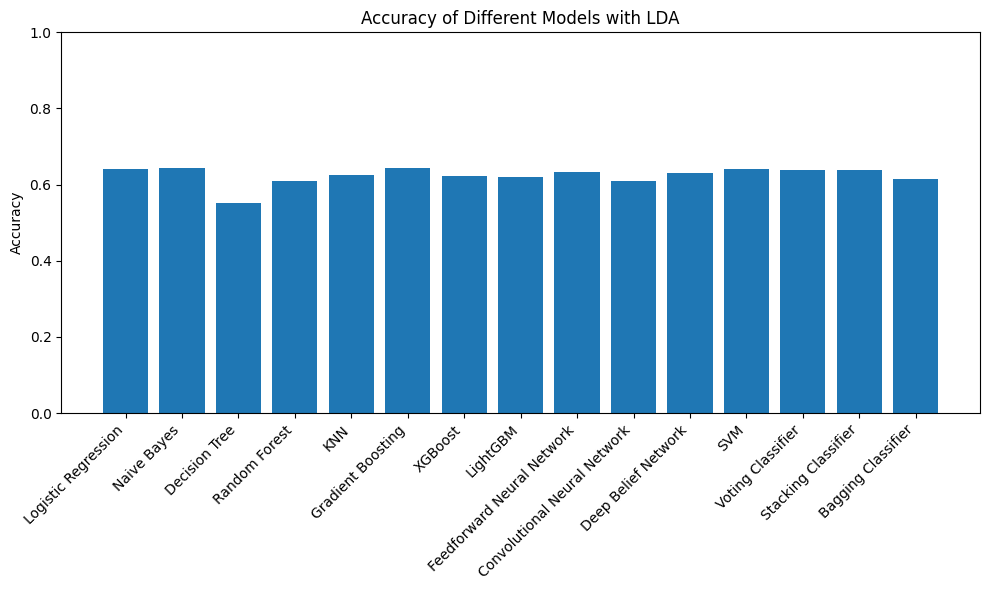

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import xgboost as xgb
import lightgbm as lgb
import time
import matplotlib.pyplot as plt

# Load data from CSV
data = pd.read_csv('/kaggle/input/wav2veccremaextracted/ExtractedFeaturesForCremaDatasetWav2Vec.csv')

# Separate features (X) and labels (y)
X = data.drop(columns=['Emotions','Path'])
y = data['Emotions']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Splitting the dataset into train and test sets
X_train, X_test, y_train_encoded, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Scale features using RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize LDA
lda = LDA()

# Fit LDA on the training data and transform both training and test data
X_train_lda = lda.fit_transform(X_train_scaled, y_train_encoded)
X_test_lda = lda.transform(X_test_scaled)

# Display the number of components retained after LDA
print(f'Number of components retained after LDA: {lda.explained_variance_ratio_.shape[0]}')

# Reshape data for CNN input after LDA
X_train_lda_cnn = X_train_lda.reshape(X_train_lda.shape[0], X_train_lda.shape[1], 1)
X_test_lda_cnn = X_test_lda.reshape(X_test_lda.shape[0], X_test_lda.shape[1], 1)

# Initializing models
models = {
    'Logistic Regression': LogisticRegression(C=1.0, penalty='l2'),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(max_depth=5),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=5),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1),
    'XGBoost': xgb.XGBClassifier(),
    'LightGBM': lgb.LGBMClassifier(),
    'Feedforward Neural Network': Sequential([
        Dense(128, activation='relu', input_shape=(X_train_lda.shape[1],)),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ]),
    'Convolutional Neural Network': Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_lda_cnn.shape[1], X_train_lda_cnn.shape[2])),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ]),
    'Deep Belief Network': Sequential([
        Dense(128, activation='relu', input_shape=(X_train_lda.shape[1],)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ]),
    'SVM': SVC(kernel='linear')
}

# Initialize base models
base_models = [
    ('Logistic Regression', LogisticRegression(C=1.0, penalty='l2')),
    ('Naive Bayes', GaussianNB()),
    ('Decision Tree', DecisionTreeClassifier(max_depth=5)),
    ('Random Forest', RandomForestClassifier(n_estimators=100, max_depth=5)),
    ('KNN', KNeighborsClassifier(n_neighbors=5)),
    ('Gradient Boosting', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1))
]

# Initialize ensemble methods
ensemble_methods = {
    'Voting Classifier': VotingClassifier(estimators=base_models),
    'Stacking Classifier': StackingClassifier(estimators=base_models, final_estimator=LogisticRegression()),
    'Bagging Classifier': BaggingClassifier(base_estimator=DecisionTreeClassifier())
}

# Include ensemble methods in the models dictionary
models.update(ensemble_methods)

# Lists to store accuracy values
accuracies = []

# Training and evaluating each model with LDA-transformed data
for name, model in models.items():
    start_time = time.time()
    
    if name == 'Feedforward Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_lda, y_train_encoded, epochs=20, batch_size=64, verbose=0)
    elif name == 'Convolutional Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_lda_cnn, y_train_encoded, epochs=20, batch_size=64, verbose=0)
    elif name == 'Deep Belief Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_lda, y_train_encoded, epochs=20, batch_size=64, verbose=0)
    else:
        model.fit(X_train_lda, y_train_encoded)
    
    train_time = time.time() - start_time
    
    start_time = time.time()
    if name in ['Feedforward Neural Network', 'Convolutional Neural Network', 'Deep Belief Network']:
        y_pred_proba = model.predict(X_test_lda)
        y_pred = y_pred_proba.argmax(axis=-1)
    else:
        y_pred = model.predict(X_test_lda)
    
    predict_time = time.time() - start_time
    
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)  # Store accuracy
    
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f'{name} with LDA: Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}, Training Time = {train_time:.4f} s, Prediction Time = {predict_time:.4f} s')

# Plotting accuracies
plt.figure(figsize=(10, 6))
plt.bar(models.keys(), accuracies)
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Models with LDA')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


Number of components retained after LDA: 5


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Logistic Regression with LDA: Accuracy = 0.4090, Precision = 0.4106, Recall = 0.4090, F1 Score = 0.4093, Training Time = 0.0408 s, Prediction Time = 0.0005 s
Naive Bayes with LDA: Accuracy = 0.4258, Precision = 0.4242, Recall = 0.4258, F1 Score = 0.4232, Training Time = 0.0038 s, Prediction Time = 0.0013 s
Decision Tree with LDA: Accuracy = 0.3721, Precision = 0.3917, Recall = 0.3721, F1 Score = 0.3731, Training Time = 0.0216 s, Prediction Time = 0.0005 s
Random Forest with LDA: Accuracy = 0.4070, Precision = 0.4073, Recall = 0.4070, F1 Score = 0.4047, Training Time = 0.8753 s, Prediction Time = 0.0237 s
KNN with LDA: Accuracy = 0.4003, Precision = 0.3995, Recall = 0.4003, F1 Score = 0.3996, Training Time = 0.0051 s, Prediction Time = 0.1138 s
Gradient Boosting with LDA: Accuracy = 0.4077, Precision = 0.4074, Recall = 0.4077, F1 Score = 0.4070, Training Time = 9.3253 s, Prediction Time = 0.0167 s
XGBoost with LDA: Accuracy = 0.4130, Precision = 0.4128, Recall = 0.4130, F1 Score = 0.412

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Stacking Classifier with LDA: Accuracy = 0.4150, Precision = 0.4164, Recall = 0.4150, F1 Score = 0.4150, Training Time = 50.1830 s, Prediction Time = 0.1257 s
Bagging Classifier with LDA: Accuracy = 0.3922, Precision = 0.3901, Recall = 0.3922, F1 Score = 0.3907, Training Time = 0.3704 s, Prediction Time = 0.0063 s


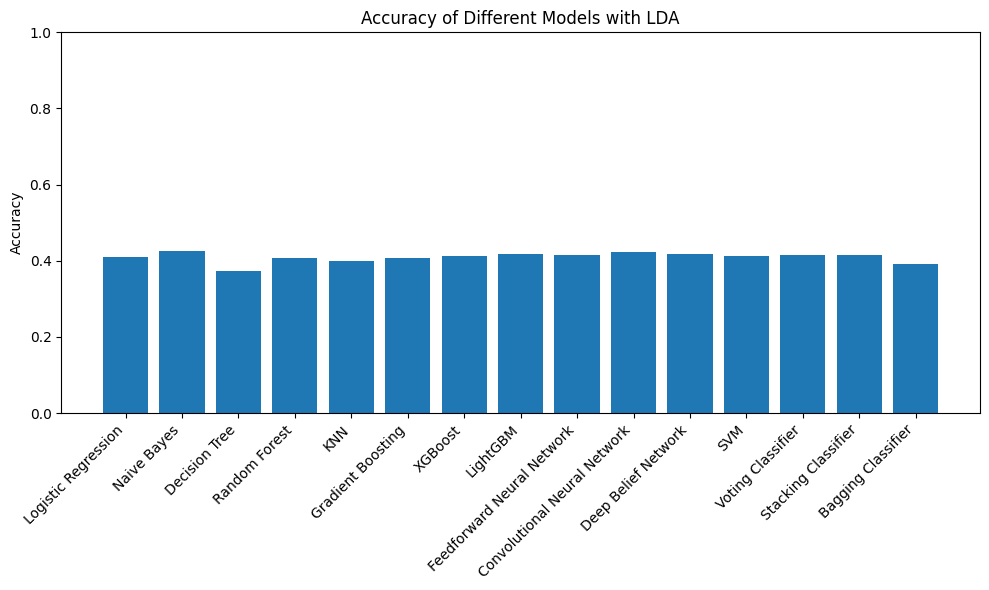

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import xgboost as xgb
import lightgbm as lgb
import time
import matplotlib.pyplot as plt

# Load data from CSV
data = pd.read_csv('/kaggle/input/cremalibrosaextracted/ExtractedFeaturesForCremaDatasetLibrosaCleanedNa.csv')

# Separate features (X) and labels (y)
X = data.drop(columns=['Emotions'])
y = data['Emotions']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Splitting the dataset into train and test sets
X_train, X_test, y_train_encoded, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Scale features using RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize LDA
lda = LDA()

# Fit LDA on the training data and transform both training and test data
X_train_lda = lda.fit_transform(X_train_scaled, y_train_encoded)
X_test_lda = lda.transform(X_test_scaled)

# Display the number of components retained after LDA
print(f'Number of components retained after LDA: {lda.explained_variance_ratio_.shape[0]}')

# Reshape data for CNN input after LDA
X_train_lda_cnn = X_train_lda.reshape(X_train_lda.shape[0], X_train_lda.shape[1], 1)
X_test_lda_cnn = X_test_lda.reshape(X_test_lda.shape[0], X_test_lda.shape[1], 1)

# Initializing models
models = {
    'Logistic Regression': LogisticRegression(C=1.0, penalty='l2'),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(max_depth=5),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=5),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1),
    'XGBoost': xgb.XGBClassifier(),
    'LightGBM': lgb.LGBMClassifier(),
    'Feedforward Neural Network': Sequential([
        Dense(128, activation='relu', input_shape=(X_train_lda.shape[1],)),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ]),
    'Convolutional Neural Network': Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_lda_cnn.shape[1], X_train_lda_cnn.shape[2])),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ]),
    'Deep Belief Network': Sequential([
        Dense(128, activation='relu', input_shape=(X_train_lda.shape[1],)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ]),
    'SVM': SVC(kernel='linear')
}

# Initialize base models
base_models = [
    ('Logistic Regression', LogisticRegression(C=1.0, penalty='l2')),
    ('Naive Bayes', GaussianNB()),
    ('Decision Tree', DecisionTreeClassifier(max_depth=5)),
    ('Random Forest', RandomForestClassifier(n_estimators=100, max_depth=5)),
    ('KNN', KNeighborsClassifier(n_neighbors=5)),
    ('Gradient Boosting', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1))
]

# Initialize ensemble methods
ensemble_methods = {
    'Voting Classifier': VotingClassifier(estimators=base_models),
    'Stacking Classifier': StackingClassifier(estimators=base_models, final_estimator=LogisticRegression()),
    'Bagging Classifier': BaggingClassifier(base_estimator=DecisionTreeClassifier())
}

# Include ensemble methods in the models dictionary
models.update(ensemble_methods)

# Lists to store accuracy values
accuracies = []

# Training and evaluating each model with LDA-transformed data
for name, model in models.items():
    start_time = time.time()
    
    if name == 'Feedforward Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_lda, y_train_encoded, epochs=20, batch_size=64, verbose=0)
    elif name == 'Convolutional Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_lda_cnn, y_train_encoded, epochs=20, batch_size=64, verbose=0)
    elif name == 'Deep Belief Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_lda, y_train_encoded, epochs=20, batch_size=64, verbose=0)
    else:
        model.fit(X_train_lda, y_train_encoded)
    
    train_time = time.time() - start_time
    
    start_time = time.time()
    if name in ['Feedforward Neural Network', 'Convolutional Neural Network', 'Deep Belief Network']:
        y_pred_proba = model.predict(X_test_lda)
        y_pred = y_pred_proba.argmax(axis=-1)
    else:
        y_pred = model.predict(X_test_lda)
    
    predict_time = time.time() - start_time
    
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)  # Store accuracy
    
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f'{name} with LDA: Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}, Training Time = {train_time:.4f} s, Prediction Time = {predict_time:.4f} s')

# Plotting accuracies
plt.figure(figsize=(10, 6))
plt.bar(models.keys(), accuracies)
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Models with LDA')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()
